# Smoothly Interpolating Shortest Path and Resistance Distances

The "Forest Distances" i.e. Regularized Laplacian Kernels

In [1]:
# generic
import networkx as nx
import seaborn as sns 
import numpy as np
import pandas as pd

# scipy
from scipy.spatial.distance import squareform, pdist
from scipy.sparse.csgraph import (
    minimum_spanning_tree, 
    csgraph_from_dense, 
    breadth_first_tree, 
    shortest_path
)
from scipy.sparse import coo_array, csr_array
from scipy import sparse as sprs
from scipy.integrate import trapezoid,cumulative_trapezoid
from scipy.stats import Covariance, multivariate_normal, percentileofscore
from scipy.special import softmax

# scikit-learn
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn.covariance import GraphicalLassoCV, GraphicalLasso
from sklearn.preprocessing import StandardScaler,normalize

# misc utils
from functools import partial, cache
from itertools import count, cycle, islice, combinations
from toolz.curried import groupby, mapcat, sliding_window, flip

# plotting/viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
from cycler import cycler
from tqdm.autonotebook import tqdm, trange
# from pydlc import dense_lines

/tmp/ipykernel_4092138/3344216433.py:36: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
rng = np.random.default_rng(42)
sns.set_theme(style='white')

In [69]:
# affinis imports
from affinis.metrics import f_beta
from affinis.utils import (
    _norm_diag,
    _e_to_ij, 
    _std_incidence_vec, 
    _sq, 
    _outer,
    sparse_adj_to_incidence,
)
from affinis.distance import (
    bilinear_dists, 
    adjusted_forest_dists, 
    generalized_graph_dists,
)
from affinis.associations import (
    coocur_prob,
    odds_ratio,
    mutual_information,
    chow_liu,
    yule_q, yule_y,
    ochiai,
    resource_project,
    high_salience_skeleton, 
    SFD_edge_cond_prob,
    SFD_interaction_prob,
)
from affinis.proximity import forest, forest_correlation, sinkhorn
from affinis.sample import _random_cut, _random_bridge
from affinis.plots import hinton

In [4]:
n_authors=25
author_idx = pd.CategoricalIndex((f'author_{i:>02}' for i in range(1,n_authors+1)))

# friendships = nx.random_internet_as_graph(n_authors)
# friendships = nx.random_graphs.barabasi_albert_graph(n_authors, 2)

# friends with some cliques
friendships = nx.line_graph(nx.random_tree(len(author_idx)+1, seed=7)) # real events... what "happens" as evidence of a relationship

G = nx.relabel.relabel_nodes(nx.convert_node_labels_to_integers(friendships),dict(zip(range(n_authors),author_idx.categories.tolist())))  # inferred structure

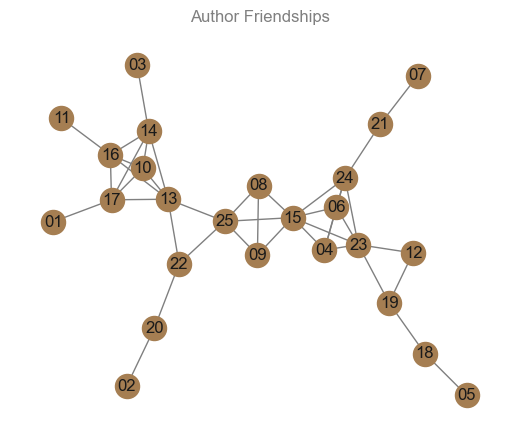

In [5]:
def draw_G(G, ax=None):
    
    pos=nx.layout.kamada_kawai_layout(G)
    nx.draw(G, pos=pos, 
            node_color='xkcd:puce', edge_color='grey', ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_color='k',labels={n:n.split('_')[-1] for n in G}, ax=ax)
    plt.title('Author Friendships', color='grey')
    return pos
f = plt.figure(figsize=(5,4)).patch.set_alpha(0.)
pos = draw_G(G)

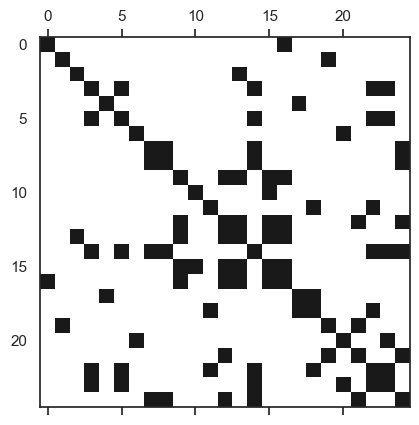

In [6]:
A = nx.adjacency_matrix(G).todense()
L = nx.laplacian_matrix(G).todense()
plt.spy(L)
# np.asarray(A)

<Axes: >

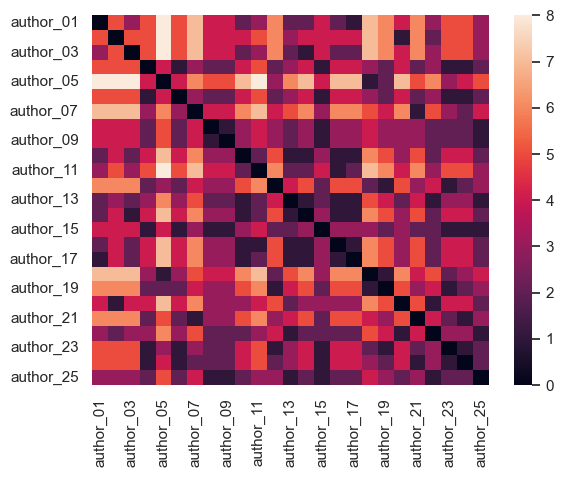

In [7]:
ap_sp = pd.DataFrame.from_dict({k:v for k,v in nx.all_pairs_shortest_path_length(G)}).sort_index()
sns.heatmap(ap_sp)
# sns.heatmap(_squareform(prox_to_edgeprob(1-np.log(ap_sp+1).values)))
# -np.log(ap_sp+1)

In [8]:
x = np.logspace(-2,2)
ys = np.vstack([_sq(forest(nx.laplacian_matrix(G), beta=i)) for i in x])
# ys = np.vstack([prox_to_edgeprob(forest(nx.laplacian_matrix(G), beta=i)) for i in x])

ys.shape

(50, 300)

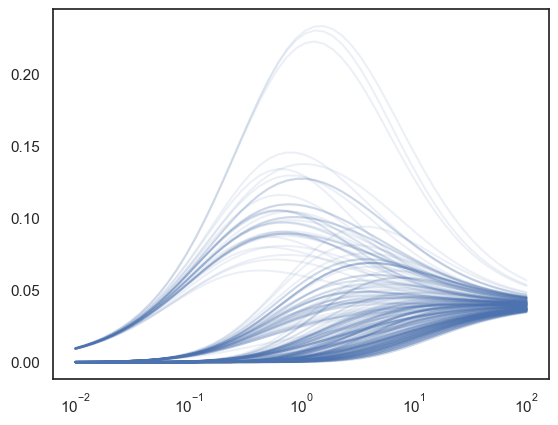

In [9]:
plt.plot(x, ys, color='b', alpha=.1);
# plt.yscale('log')
plt.xscale('log')

In [10]:
# im = dense_lines(ys.T,x=x, cmap='cividis', ny=50, norm=LogNorm())
# plt.yscale('log')
# plt.colorbar(im)
# x

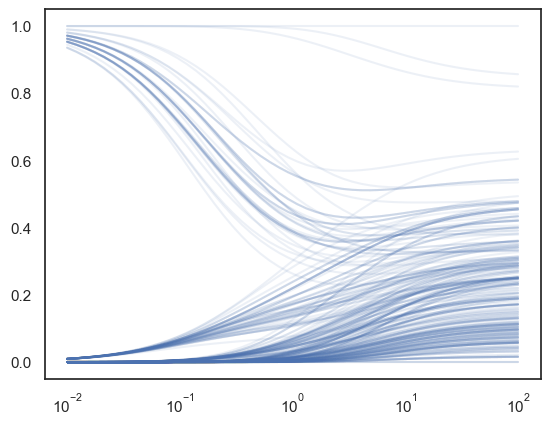

In [11]:
def minmax(x, axis=None): 
    return np.subtract(x,x.min(axis=axis))/np.subtract(x.max(axis=axis),x.min(axis=axis))

plt.plot(x,minmax(ys.T, axis=0).T, color='b', alpha=0.1);
plt.xscale('log')

## Structure Recovery

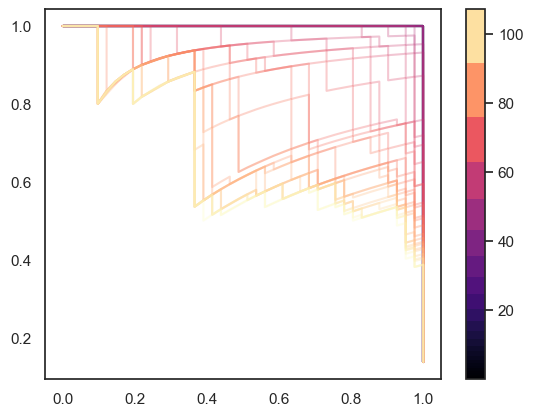

In [12]:
true = _sq(np.diag(np.diag(L))-L)  # True Adjacency
pre,rec,thr = zip(*map(partial(precision_recall_curve, true), ys))

color = plt.cm.magma(np.linspace(0,1,x.shape[0]))
for p,r,c in zip(pre,rec, color):
    plt.plot(r,p, color=c, alpha=.3)
    
plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax = plt.gca(), values=x )
# print([i[[0,-1]] for i in thr])

## Generate Data

In [13]:
# rng = np.random.default_rng()

# cov = Covariance.from_precision(np.eye(n_authors) + L)
# X = multivariate_normal(cov=cov).rvs(200) < -0.95


def sim_papers(n_weeks, L, jumps_param=0.1, rng=np.random.default_rng(2)): 
    Arw = ((L/np.diag(L)).pipe(lambda df: np.diag(np.diag(df))-df)*0.5)
    def sim_week(): 
        n_jumps = rng.geometric(jumps_param)
        first = rng.multinomial(1,starting:=np.ones(n_authors)/n_authors) 
        # second = (rng.random()>0.5)*rng.multinomial(1,starting)  # maybe
        infected = first #| second
        for jump in range(n_jumps):
            # print((Arw@infected>1).sum(), infected)
            infected = infected | rng.binomial(1, Arw@(infected/infected.sum()))
        return infected


    yield from (sim_week() for i in range(n_weeks))

# n_obs ~ neg_binom(2, 1/n_nodes)
# n_jumps ~ geom(2/n_nodes)
X = np.vstack(list(sim_papers(
    50, 
    pd.DataFrame(L, columns=author_idx, index=author_idx), 
    0.05,
    #  rng=rng
)))

Xstack = np.vstack([X, -X])#.mean(axis=0)
# Xstack.mean(axis=0)

/tmp/ipykernel_4092138/700962374.py:3: RuntimeWarning: Mean of empty slice.
  plt.plot([1-true[_sq(X.T@X)<i].mean() for i in range(15)], label='TNR')
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


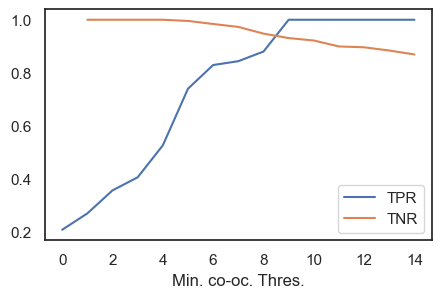

In [14]:
plt.figure(figsize=(5,3))
plt.plot([true[_sq(X.T@X)>i].mean() for i in range(15)], label='TPR')
plt.plot([1-true[_sq(X.T@X)<i].mean() for i in range(15)], label='TNR')
plt.xlabel('Min. co-oc. Thres.')
plt.legend()

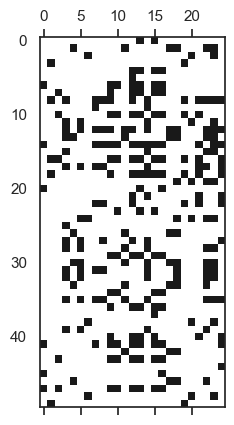

In [15]:
plt.spy(X)
# rng.geometric(0.05)

### Interpreting co-occurrence data in a causal setting

> what exactly to the co-occurrences... approximate? 

Forest accessibility matrices are measuring the fraction of spanning forests where two nodes are "linked", i.e. they exist in the same spanning _tree_, within the forest. 
They are also (provably) _always_ doubly-stochastic. 

In a sense, two nodes in the same spanning tree can be "observed" as coming from the same chain. 
If we assume that our data is conditional on coming from single random walks/cascades/etc. (e.g. for each paper in a citation dataset, or each paper in a co-author dataset), then the co-occurrence counts should be a sample estimator for the forest matrix. 

Sinkorn-Knopp takes a square matrix and projects it onto the closest point in the birkhoff polytope (space of doubly-stochastic matrices).

<Axes: ylabel='Density'>

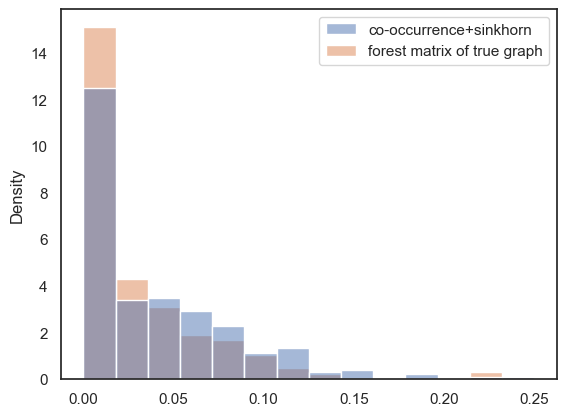

In [16]:
sns.histplot(pd.DataFrame(
    data={
        'co-occurrence+sinkhorn':_sq(sinkhorn(_sq(_sq(X.T@X)))), 
        'forest matrix of true graph': _sq(forest(L, beta=2)),
    }
), stat='density', bins=np.linspace(0,0.25,15))

Similarly there's a rough correspondence between cosine-sim and forest correlations. 

We treat the cosine similarity (Ochiai coeff.) as the sample estimator of the forrest correlation matrix --- both are just cosine-law rescalings of the above plots (except we don't need to use sinkhorn-knopp... the diagonal is 1 already).

<Axes: >

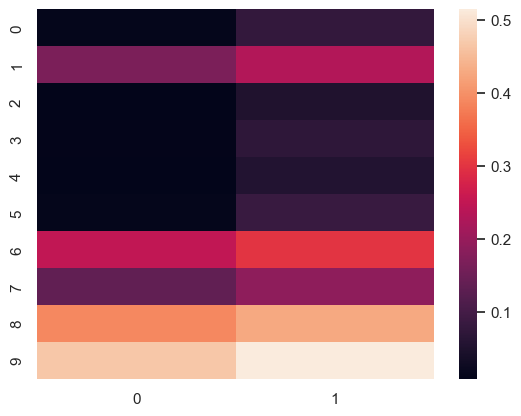

In [17]:
# from affinis.priors import pseudocount
psct = ('zero-sum','min-connect')
sns.heatmap(
    np.array([_sq(ochiai(X, pseudocts=psct)),
              _sq(ochiai(X, pseudocts=0.5))]).T[:10]
)

<Axes: ylabel='Density'>

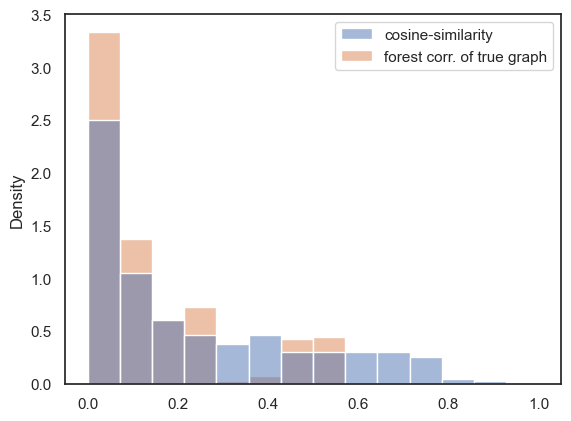

In [18]:
sns.histplot(pd.DataFrame(
    data={
        'cosine-similarity':_sq(ochiai(X, pseudocts=psct)), 
        'forest corr. of true graph': _sq(forest_correlation(L, beta=2)),
    }
), stat='density', bins=np.linspace(0,1,15))

## Noisy Structure Recovery (Inverse Problem)

In [19]:
def prox_to_laplacian(K):
    A = -_sq(_sq(K))
    np.fill_diagonal(A,-A.sum(axis=0))
    return A

baselines = {
    # 'co-occur':_sq(coocur_prob(X, pseudocts=1.)),
    'cosine': _sq(ochiai(X, pseudocts=psct)),
    'sinkhornOTP': _sq(sinkhorn(_sq(_sq(X.T@X)), err=1e-8)),
    'resourceProj': _sq(resource_project(X)),
    'odds-ratio': _sq(odds_ratio(X, pseudocts=psct)),
    # 'yuleQ':_sq(yule_q(X, pseudocts=psct)),
    'yuleY':_sq(yule_y(X, pseudocts=psct)),

    # 'yuley': prox_to_edgeprob(yule_y(X)),
    'mutualinfo': _sq(mutual_information(X, pseudocts=psct)),
    # 'yuleq':np.arcsin(prox_to_edgeprob(yule_y(X)))/np.pi +0.5,
    'glasso': -_sq(GraphicalLasso().fit(X).get_precision()),
    # 'chow-liu':_sq((chow_liu(X, pseudocts=psct)>0.).astype(int)), 
    'HSS': _sq(high_salience_skeleton(X))


    # 'sinkhorn-cos': _squareform(sinkhorn(cos - np.diag(np.diag(cos)), err=1e-8)),
}

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.408e-04
  warnings.warn(


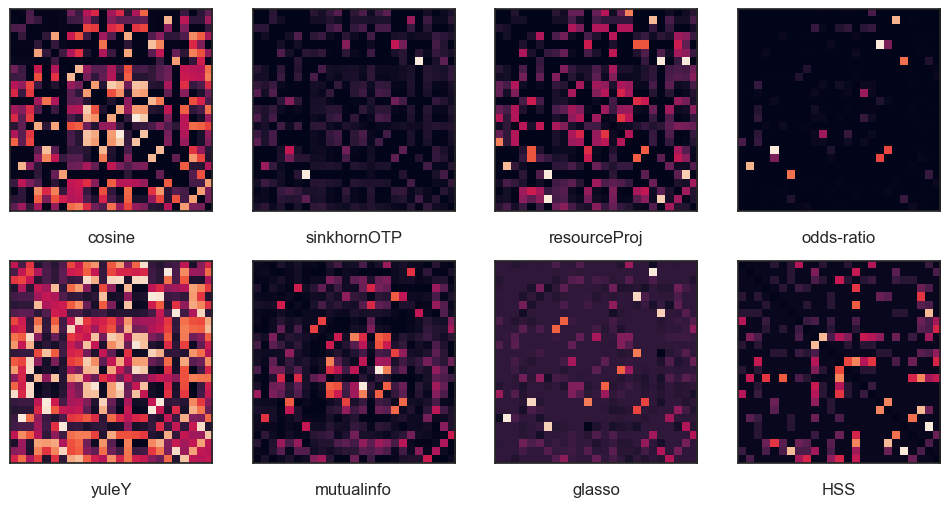

In [20]:
f,axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

for n, (lab, Aest) in enumerate(baselines.items()): 
    ax = axs.flatten()[n]
    ax.imshow(_sq(Aest))
    ax.set_xlabel(lab)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

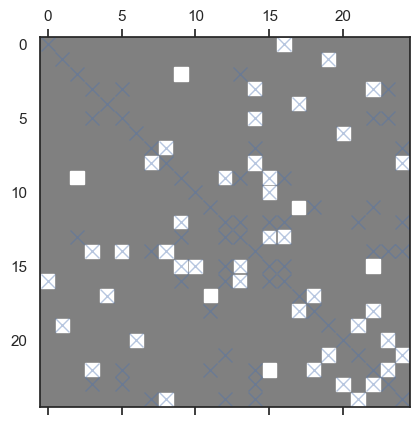

In [21]:
hinton(chow_liu(X, pseudocts=1))
# hinton(mutual_information(X))
# hinton(_sq(_sq(minimum_spanning_tree(np.exp(-(mutual_information(X, pseudocts=)))).todense())))

# hinton(minimum_spanning_tree(np.exp(-np.nan_to_num(mutual_information(X)))).todense())
plt.spy(L, marker='x', alpha=0.4)
# hinton(ochiai(X, pseudocts=0.1))

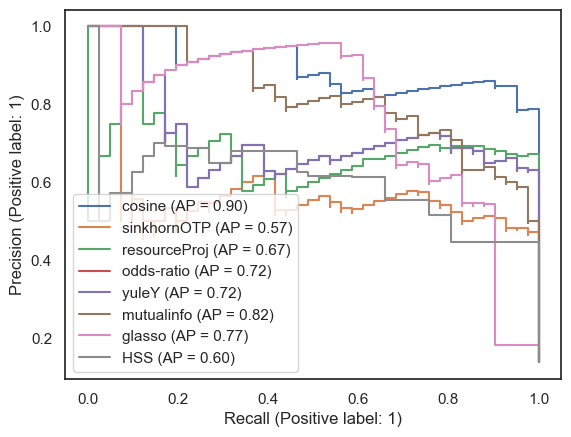

In [22]:
from sklearn.metrics import PrecisionRecallDisplay

for lab,Aest in baselines.items():
    PrecisionRecallDisplay.from_predictions(true, Aest, name=lab, ax=plt.gca())    
    # p,r,t = precision_recall_curve(true, Aest)
    # plt.plot(np.tanh(r-p),np.tanh(r+p), label=lab)
    # plt.step(r,p,label=lab)
    
# plt.legend(loc='lower left')

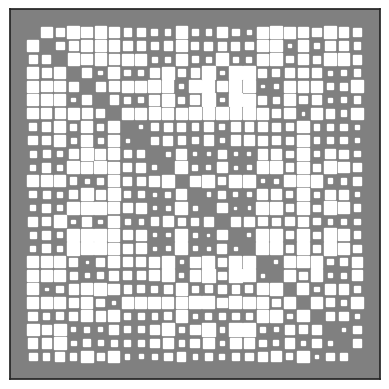

In [24]:
def approx_dists(X): 
    Q_apprx = sinkhorn(coocur_prob(X, pseudocts=0.5))
    norm = np.sqrt(np.multiply.outer(q_ii:=np.diag(Q_apprx), q_ii))
    return -np.log(Q_apprx/norm)

hinton(approx_dists(X))

In [27]:
papers=pd.DataFrame(X, columns=author_idx)

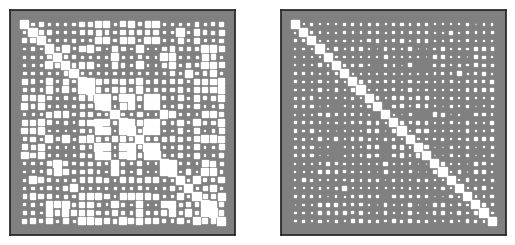

In [28]:
sp_papers = csr_array(papers.values)
src,tgt = list(zip(*mapcat(
    flip(combinations,2), 
    map(lambda pair: sp_papers.indices[pair[0]:pair[1]], 
        sliding_window(2,sp_papers.indptr)
       )
)))
shap = (len(tgt), n_authors)
def stack_with_negation(B): 
    return np.vstack((B,-B))
B_papers = pd.DataFrame(
    ( 
        coo_array((np.ones(shap[0]), (np.arange(shap[0]),tgt)), shape=shap)
        -
        coo_array((np.ones(shap[0]), (np.arange(shap[0]),src)), shape=shap)
    ).todense(), columns=author_idx
)

Ws = np.diag(np.array(list(mapcat(lambda i: (comb:=i*(i-1)//2)*[i], papers.sum(axis=1).tolist()))))
L_papers=(B_papers.T@Ws@B_papers)
plt.subplot(121)
hinton(ochiai(papers.values))
plt.subplot(122)
hinton(ochiai(np.abs(B_papers).values))

array([[0.        , 0.2586877 , 0.2042776 , 0.21042097, 0.28029563,
        0.20980368, 0.36549686, 0.14873565, 0.17345988, 0.11431281,
        0.10591967, 0.22132016, 0.12150453, 0.10399383, 0.17148756,
        0.12608181, 0.08170373, 0.23657273, 0.20759004, 0.22658866,
        0.31615009, 0.17308059, 0.18696456, 0.16428642, 0.14871843],
       [0.2586877 , 0.        , 0.18945336, 0.17376386, 0.26738085,
        0.19689508, 0.35257496, 0.160023  , 0.1594127 , 0.11541063,
        0.16891582, 0.20841024, 0.12105842, 0.145321  , 0.13981828,
        0.14859419, 0.1437001 , 0.22366157, 0.19468183, 0.03514789,
        0.30323378, 0.10695452, 0.15633788, 0.15073912, 0.11473457],
       [0.2042776 , 0.18945336, 0.        , 0.18850772, 0.25838188,
        0.1878904 , 0.34358257, 0.17733908, 0.17860401, 0.07611933,
        0.08368044, 0.19940677, 0.08510657, 0.08178538, 0.16688148,
        0.08538802, 0.07861497, 0.21465925, 0.18567678, 0.13592781,
        0.29423623, 0.12597859, 0.16505143, 0.

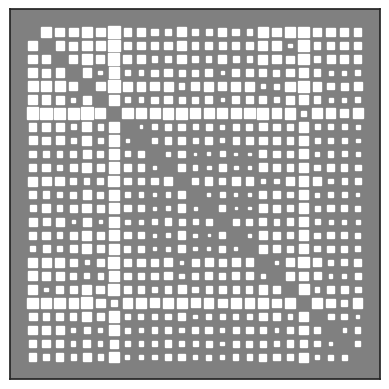

In [29]:
# from affinis.utils import sparse_adj_to_incidence

# def norm_B(B): 
#     invdeg = 1./np._sqrt(np.abs(B).sum(axis=0))
#     return B@np.diag(np.nan_to_num(invdeg, nan=0.))

# def norm_diag(L): 
#     return (Dinv:=np.diag(np._sqrt(1/np.diag(L))))@L@Dinv

def get_mask(e_pmf,idx):
    return coo_array(_sq(e_pmf)*np.multiply.outer(idx,idx))

Xdf = papers.assign(root=1)
# est_dists = approx_dists(Xdf.values)

# MI_df = mutual_information(X, pseudocts=0.2)
# est_dists = -np.log(_norm_diag(MI_df))

# est_dists = np.nan_to_num(MI_df, nan=np.nanquantile(MI_df, 0.5))

est_dists = bilinear_dists(sinkhorn(coocur_prob(X, pseudocts=psct)))

hinton(est_dists)
# 1-np.log(est_dists)
est_dists

In [30]:
B_obs = sprs.vstack([
    (sparse_adj_to_incidence(minimum_spanning_tree(
        get_mask(_sq(est_dists),i)
    ))) for i in papers.values
])

# add_pmf = np.nan_to_num(_sq((np.abs(B_obs.T@B_obs).todense())/(X.T@X)))
# add_pmf = E_obs.mean(axis=0)
# smooth_pmf = (add_pmf+np.where(add_pmf==0., 1, add_pmf))/(add_pmf.sum())
# smooth_pmf = (lambda odds: odds/(odds+1))(add_pmf/(1-add_pmf) +0.5)
# hinton(_sq(add_pmf))
# plt.spy(L, marker='x', alpha=0.6)
smooth_pmf = _sq((np.abs(B_obs.T@B_obs).todense()+0.5)/(1+np.sqrt(_outer(np.multiply, X.sum(axis=0)))))
# PrecisionRecallDisplay.from_predictions(true,smooth_pmf)
# add_pmf

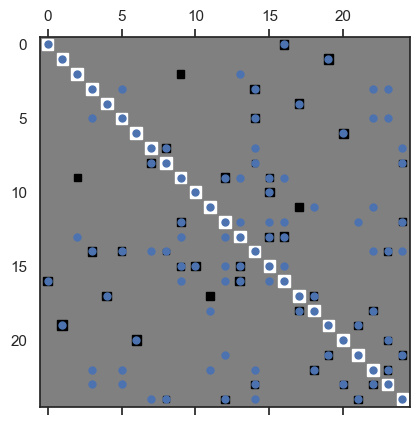

In [31]:
# from scipy.sparse.linalg import
# hinton(forest_correlation(L, beta=5)/n_authors)

# PrecisionRecallDisplay.from_predictions(true,_sq(ochiai(X)))
# hinton(_sq(_sq(np.linalg.cholesky(forest(L, beta=0.2)).T)))

# hinton(np.abs(np.linalg.qr(B_obs.todense(), mode='r')))
hinton(5*_norm_diag((B_obs.T@B_obs).todense()))
plt.spy(_norm_diag(L)/n_authors, marker='.')

In [32]:
import scipy.sparse as sprs
E_obs=sprs.coo_array([_sq(minimum_spanning_tree(
        get_mask(_sq(est_dists),i)
    ).todense()>0) for i in papers.values
])

add_pmf = (E_obs.sum(axis=0)+0.5)/(E_obs.shape[0]+1)

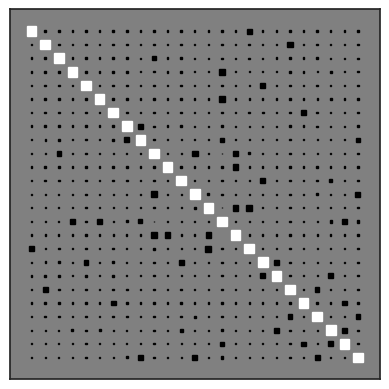

In [33]:
hinton(_norm_diag(prox_to_laplacian(_sq(add_pmf))))

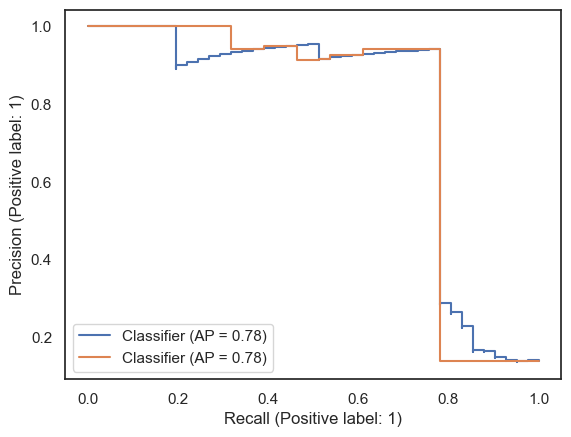

In [34]:
PrecisionRecallDisplay.from_predictions(true,-_sq(_norm_diag(prox_to_laplacian(_sq(add_pmf)))))
PrecisionRecallDisplay.from_predictions(true,add_pmf, ax=plt.gca())

/tmp/ipykernel_4092138/2922849561.py:6: RuntimeWarning: divide by zero encountered in divide
  O_prior=_sq((lambda p: p/(1-p))(ochiai(X, pseudocts=psct)))


<Axes: >

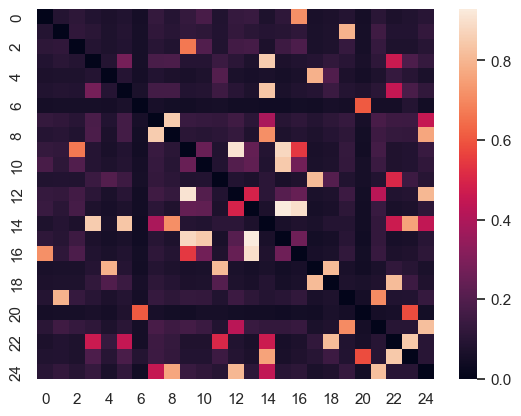

In [35]:
def prox_to_laplacian(K):
    A = -_sq(_sq(K))
    np.fill_diagonal(A,-A.sum(axis=0))
    return A

O_prior=_sq((lambda p: p/(1-p))(ochiai(X, pseudocts=psct)))
# _outer(np.multiply, X.sum(axis=0))/
# X.T@np.diag()@X
# obs_weights=1/((lambda x:(x*(x-1)/2.))(X.sum(axis=1))+1)
# obs_weights@X
# obs_weights
# np.sort(_sq(odds_ratio(X, pseudocts=1.)))
L_prior = prox_to_laplacian(ochiai(X, pseudocts=psct))
L_postr = _norm_diag(prox_to_laplacian(_sq(add_pmf)))
# sns.heatmap(_sq(_sq(bilinear_dists( np.linalg.pinv(L_prior+np.ones_like(A)/n_authors)))*_sq(-L_prior)))
E_expect = _sq(adjusted_forest_dists(L_prior, beta=5.))*_sq(-L_prior)
E_model = _sq(adjusted_forest_dists(L_postr,beta=5.))*_sq(-L_postr)
# E_model = _sq(adjusted_forest_dists(L,beta=5.))*_sq(-L_postr)
O_postr = O_prior*E_model/E_expect
P_postr = (lambda odds: odds/(1+odds))(O_postr)
sns.heatmap(_sq(P_postr))
# sns.heatmap(_sq(_sq(adjusted_forest_dists(L_prior, beta=6.))*_sq(-L_prior)))
# from scipy.linalg 

In [36]:
# hinton(_sq(E_model/E_expect))
# _sq(E_model/E_expect)
# hinton(10*(prox_to_laplacian((L_prior*L_postr*_sq(E_model)))))
# plt.spy(L, marker='x')

In [37]:
# sns.heatmap(_sq((E_obs.sum(axis=0)+0.5)/(unroll_node_obs(X).sum(axis=0)+1)*_sq(ochiai(X, pseudocts=psct))))

In [38]:
true[(np.max(E_obs, axis=0)>0).todense()[0]]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([6.53594771e-05, 4.93464052e-03, 6.53594771e-05, 6.53594771e-05,
       6.53594771e-05, 6.53594771e-05, 6.55773420e-03, 4.93464052e-03,
       7.85620915e-03, 7.85620915e-03, 6.53594771e-05, 7.85620915e-03,
       8.18082789e-03, 4.93464052e-03, 7.85620915e-03, 1.09365079e-01,
       6.53594771e-05, 6.53594771e-05, 6.53594771e-05, 6.53594771e-05,
       4.93464052e-03, 6.53594771e-05, 4.93464052e-03, 6.55773420e-03,
       4.93464052e-03, 4.93464052e-03, 6.53594771e-05, 6.53594771e-05,
       6.53594771e-05, 4.93464052e-03, 4.93464052e-03, 7.36928105e-03,
       4.93464052e-03, 6.53594771e-05, 7.36928105e-03, 6.55773420e-03,
       6.55773420e-03, 6.55773420e-03, 6.55773420e-03, 6.53594771e-05,
       6.53594771e-05, 8.99891068e-02, 6.53594771e-05, 7.36928105e-03,
       4.93464052e-03, 4.93464052e-03, 7.36928105e-03, 6.53594771e-05,
       6.53594771e-05, 6.53594771e-05, 6.53594771e-05, 6.53594771e-05,
       6.53594771e-05, 8.99891068e-02, 7.85620915e-03, 6.53594771e-05,
      

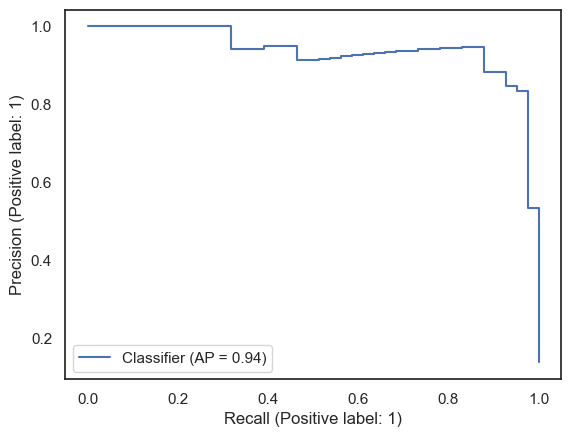

In [39]:
def unroll_node_obs(X): 
    trirow, tricol = np.triu_indices(X.shape[1], k=1)
    return np.einsum('ij,ik->ijk', X, X)[:,trirow, tricol]

PrecisionRecallDisplay.from_predictions(
    true,
    # (E_obs.sum(axis=0)+0.5)/(unroll_node_obs(X).sum(axis=0)+1)*_sq(coocur_prob(X, pseudocts=psct))
    (E_obs.sum(axis=0)+0.5)*_sq(coocur_prob(X, pseudocts=psct))/_sq(X.T@X+1)
)
(E_obs.sum(axis=0)+0.5)/(unroll_node_obs(X).sum(axis=0)+1)*_sq(coocur_prob(X, pseudocts=psct))

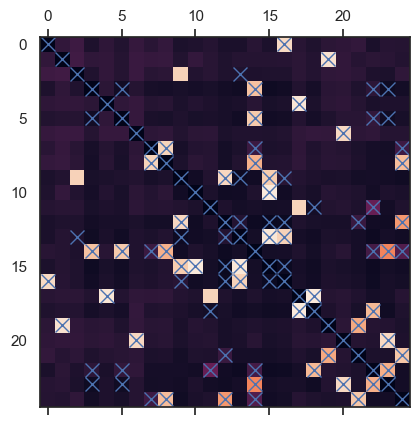

In [40]:
# plt.imshow((coocur_prob(X, pseudocts=psct)/(X.T@X+1)))#/(unroll_node_obs(X).sum(axis=0) - _sq(X.T@X)
plt.imshow(((lambda o:o/(o+1))(np.sqrt((odds_ratio(X, pseudocts=psct)))))*_sq(E_obs.sum(axis=0)+0.5)/((X.T@X)+1))
plt.spy(L, marker='x')
# from sklearn.linear_model import LogisticRegression
# from sklearn.multioutput import MultiOutputClassifier
# E_obs.toarray().astype(int), unroll_node_obs(X)
# logmod = MultiOutputClassifier(LogisticRegression()).fit(unroll_node_obs(X).T, E_obs.toarray()[:,E_obs.sum(axis=0)>0])

# [es.coef_ for es in logmod.estimators_]
# [prob.mean(axis=0) for prob in logmod.predict_proba(X.T)]

In [41]:
# mst_post = -_sq(prox_to_laplacian((L_prior*L_postr*_sq(E_model))))
# mst_post = (E_obs.sum(axis=0)+0.5)/(unroll_node_obs(X).sum(axis=0)+1)*_sq(coocur_prob(X, pseudocts=psct))

# mst_post = (E_obs.sum(axis=0)+0.5)*_sq((lambda o:o/(o+1))(np.sqrt((odds_ratio(X, pseudocts=psct)))))/(_sq(X.T@X)+1)

mst_post = _sq(SFD_interaction_prob(X, pseudocts=psct))
# mst_post = (E_obs.sum(axis=0)+0.5)*_sq(coocur_prob(X, pseudocts=psct))/(_sq(X.T@X)+1)



mst_post
# P_postr

array([1.04575163e-05, 7.89542484e-04, 1.04575163e-05, 1.04575163e-05,
       1.04575163e-05, 1.04575163e-05, 1.04923747e-03, 7.89542484e-04,
       1.25699346e-03, 1.25699346e-03, 1.04575163e-05, 1.25699346e-03,
       1.30893246e-03, 7.89542484e-04, 1.25699346e-03, 1.02298413e-01,
       1.04575163e-05, 1.04575163e-05, 1.04575163e-05, 1.04575163e-05,
       7.89542484e-04, 1.04575163e-05, 7.89542484e-04, 1.04923747e-03,
       7.89542484e-04, 7.89542484e-04, 1.04575163e-05, 1.04575163e-05,
       1.04575163e-05, 7.89542484e-04, 7.89542484e-04, 1.17908497e-03,
       7.89542484e-04, 1.04575163e-05, 1.17908497e-03, 1.04923747e-03,
       1.04923747e-03, 1.04923747e-03, 1.04923747e-03, 1.04575163e-05,
       1.04575163e-05, 8.31172113e-02, 1.04575163e-05, 1.17908497e-03,
       7.89542484e-04, 7.89542484e-04, 1.17908497e-03, 1.04575163e-05,
       1.04575163e-05, 1.04575163e-05, 1.04575163e-05, 1.04575163e-05,
       1.04575163e-05, 8.31172113e-02, 1.25699346e-03, 1.04575163e-05,
      

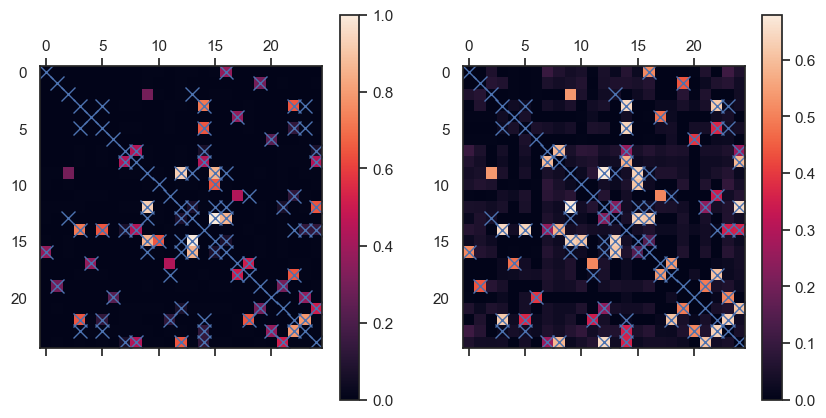

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(_sq(minmax(mst_post)))
plt.spy(L, marker='x')
plt.colorbar()
plt.subplot(122)
# plt.imshow(_sq(mst_post)/_outer(np.multiply, _sq(mst_post).sum(axis=0)))
plt.imshow(post_L:=(lambda o:o/(o+1))(_sq(mst_post)/forest(_norm_diag((lambda a: np.diag(a.sum(axis=0))-a)(_sq(mst_post))), beta=10)))
plt.colorbar()
plt.spy(L, marker='x')
# post_L

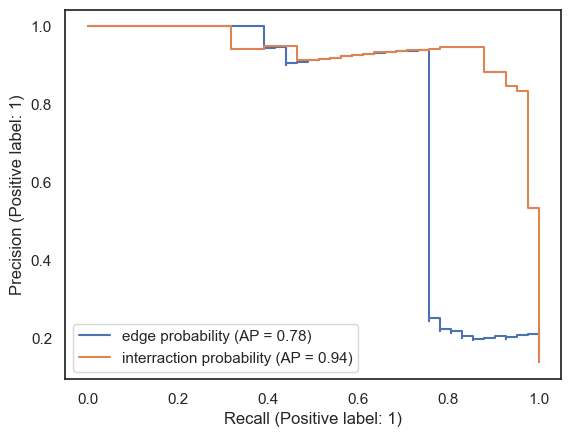

In [43]:
PrecisionRecallDisplay.from_predictions(true,_sq(post_L), name='edge probability', ax=plt.gca())
PrecisionRecallDisplay.from_predictions(
    true, 
    mst_post, 
    name='interraction probability', ax=plt.gca()
    )

<Axes: >

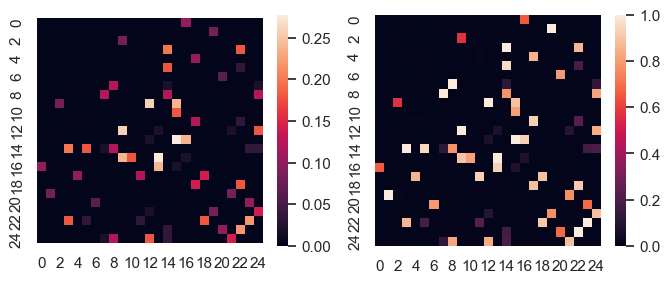

In [44]:
# sns.heatmap(_sq(mst_post)*_outer(np.multiply,2*_sq(mst_post).sum(axis=1)))
from scipy.special import logit, expit, logsumexp
# ochiai(X).sum(axis=0), X.sum(axis=0)
# coo_array(np.triu(_sq(mst_post)))
X_est = coo_array(E_obs@np.abs(np.diag(mst_post)@sparse_adj_to_incidence(coo_array(np.triu(_sq(mst_post)))))).toarray()
# sns.heatmap(np.ma.divide((X.T/X.sum(axis=1)).T, np.ma.divide(X_est.todense().T,X_est.sum(axis=1)).T))
# sns.heatmap(X_est)
f,ax = plt.subplots(ncols=2, figsize=(8,3))

sns.heatmap(_sq(mst_post),ax=ax[0], square=True)
# sns.heatmap(np.diag(7*X_est.std(axis=0))@_sq(mst_post)@np.diag(7*X_est.std(axis=0)))
# sns.heatmap(
#     _sq(mst_norm:=(lambda x: x/(1+x))(
#             (lambda x: x/(1-x))(mst_post)*_sq(
#                 _outer(
#                     np.multiply,
#                     # np.ma.divide(X_est.T,X_est.sum(axis=1)).filled(0).T.sum(axis=0)
#                     X_est.max(axis=0)
#                       )
#             ))),
#     ax=ax[1], square=True,
# )
sns.heatmap(
    _sq(mst_norm:=mst_post/_sq(_outer(
        np.multiply, 
        np.sqrt(_sq(mst_post).max(axis=0)#- _sq(mst_post).min(axis=0)
        # np.sqrt(logsumexp(_sq(mst_post), axis=0, b=0.05)), 
    )))),
    ax=ax[1]
)
# sns.heatmap(_sq(expit(*logit(mst_post))))
# 2*np.arctanh(mst_post)
# 1 + mst_post**2/

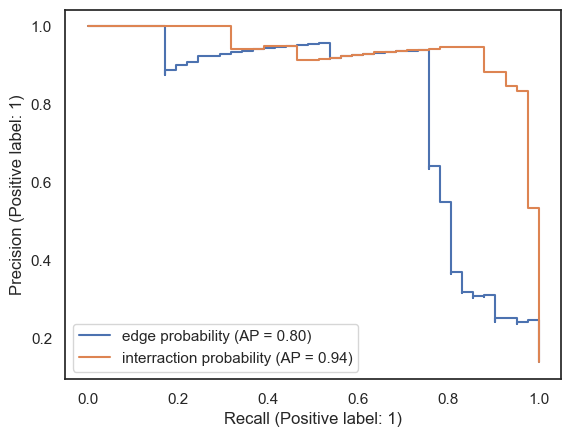

In [45]:
PrecisionRecallDisplay.from_predictions(true,mst_norm, name='edge probability', ax=plt.gca())
PrecisionRecallDisplay.from_predictions(
    true, 
    mst_post, 
    name='interraction probability', ax=plt.gca()
    )

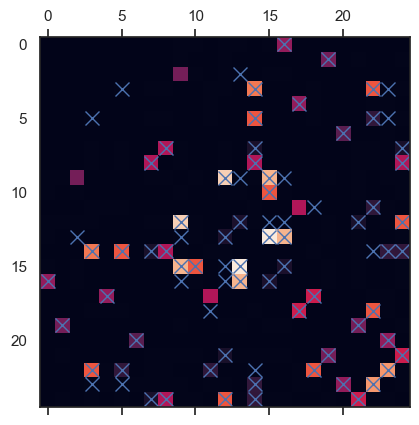

In [46]:
plt.imshow(_sq(mst_post))
plt.spy(A, marker='x')

<Axes: ylabel='Count'>

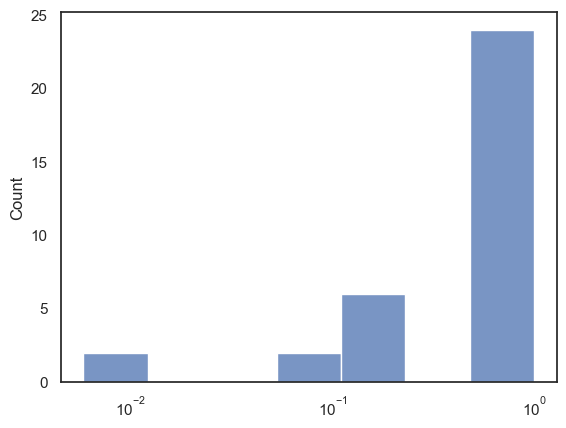

In [47]:
sns.histplot(np.ma.masked_where(E_obs.sum(axis=0)<1, mst_norm), log_scale=True)
# f,ax = plt.subplots(ncols=2)

# sns.heatmap(sinkhorn(_sq(_sq(X.T@X))), square=True, ax=ax[0])
# sns.heatmap(sinkhorn(_sq(_sq(X_est.T@X_est))), square=True, ax=ax[1])
# (X_est.T@X_est)
# hinton(np.ma.masked_greater_equal(np.ma.divide(ochiai(X),ochiai(X_est)), 0.5).filled(0))
# plt.spy(A, marker='x')

matrix([[ 6.,  5.,  5., 12.,  6., 11.,  4.,  9., 21., 33., 10.,  9., 26.,
         29., 43., 38., 20., 21., 18., 10., 10., 14., 28., 28., 28.]])

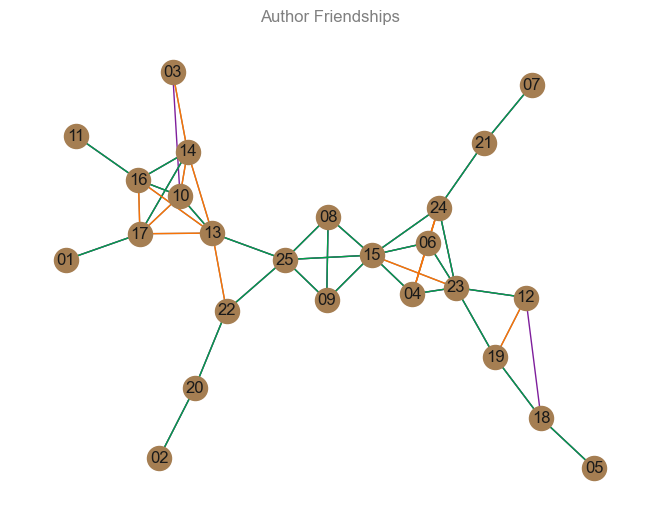

In [48]:
draw_G(G)
thres_lim = 0.1
post_L = _sq(mst_norm)
nx.draw_networkx_edges(
    nx.from_pandas_adjacency(
        pd.DataFrame((post_L>thres_lim)*_sq(_sq(~A)), columns=author_idx, index=author_idx)
    ), edge_color='xkcd:purple', pos=pos
)
nx.draw_networkx_edges(
    nx.from_pandas_adjacency(
        pd.DataFrame((post_L>thres_lim)*_sq(_sq(A)), columns=author_idx, index=author_idx)
    ), edge_color='xkcd:emerald', pos=pos
)

nx.draw_networkx_edges(
    nx.from_pandas_adjacency(
        pd.DataFrame(~(post_L>thres_lim)*_sq(_sq(A)), columns=author_idx, index=author_idx)
    ), edge_color='xkcd:orange', pos=pos
)

(B_obs.T@B_obs).todense()
np.abs(B_obs).sum(axis=0)
# draw_G(nx.from_pandas_adjacency(pd.DataFrame(_squareform(add_pmf), columns=author_idx, index=author_idx)))
# pd.DataFrame(_squareform(smooth_pmf), columns=author_idx, index=author_idx)#.astype(int)

In [49]:
np.multiply.outer(X,X).shape
np.exp(np.log(np.einsum('ij,ik->ijk', X, X)+1).sum(axis=0).sum(axis=0)**(1/X.shape[1]**2))
np.linalg.norm(np.einsum('ij,ik->jki', X, X), ord='fro', axis=(0,1))

np.linalg.norm(X[:,None,:], axis=(1,2), ord='fro')**2
X.sum(axis=1)

array([ 2,  6,  3,  2,  4,  1,  7,  6, 12,  2,  9,  5, 13,  7, 13,  4, 11,
        8, 10,  4,  3,  4,  6,  3,  6,  1,  4,  6,  6,  6,  8,  8,  6,  5,
        4,  9,  5,  1,  3,  4,  6,  9,  3,  7,  1,  2,  4,  8,  3,  2])

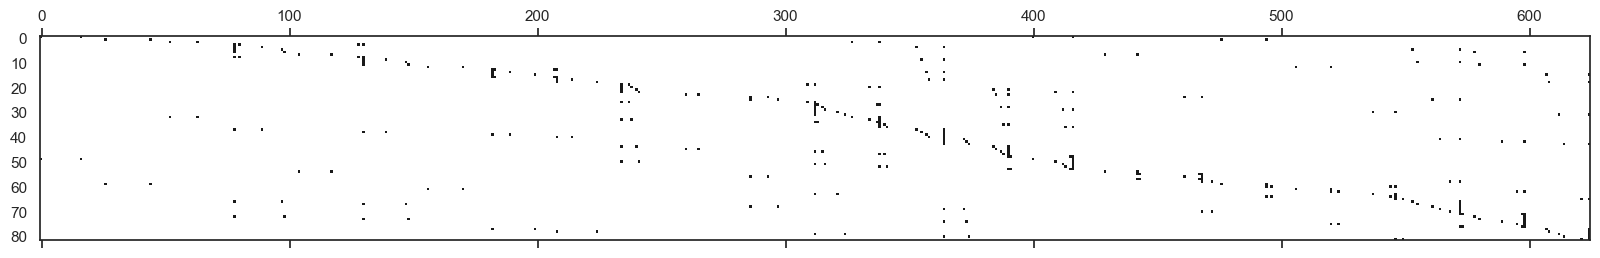

In [50]:
from affinis.utils import sparse_adj_to_incidence
B = sparse_adj_to_incidence(A).todense()
np.linalg.norm(B[:,None,:], axis=(1,2), ord='fro')**2
np.isclose(np.linalg.norm(np.einsum('ij,ik->jki', B, B)[:,:,None,:], ord='fro', axis=(2,3))**2/2,np.abs(L))
plt.figure(figsize=(20,5))
plt.spy(np.einsum('ij,ik->jki', B, B).reshape((n_authors**2,-1)).T)

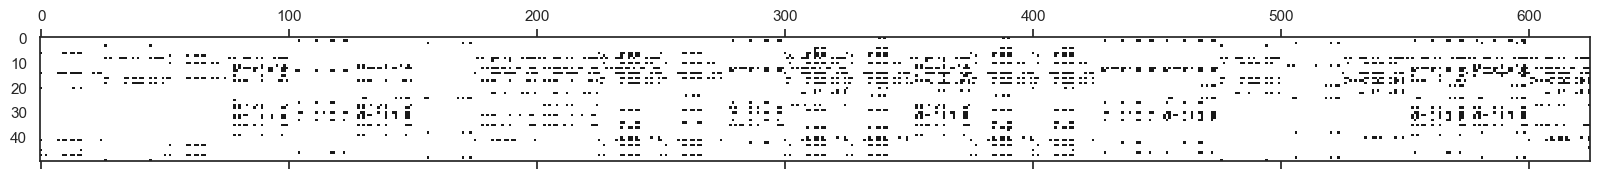

In [51]:
plt.figure(figsize=(20,5))
plt.spy(np.einsum('ij,ik->jki', X, X).reshape((n_authors**2,-1)).T)

/tmp/ipykernel_4092138/3746005801.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xsol,resid,_,_ = np.linalg.lstsq(fullB, edge_X.T)


array([[ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

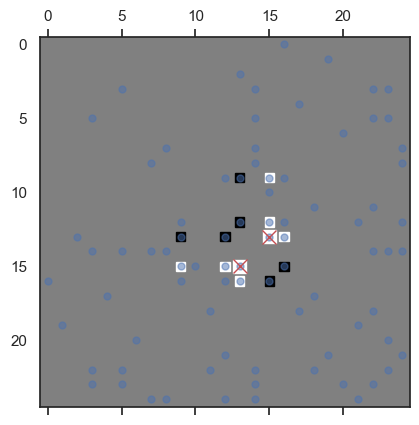

In [52]:
from affinis.utils import _diag
def unroll_node_obs(X): 
    trirow, tricol = np.triu_indices(k=1)
    return np.einsum('ij,ik->ijk', X, X)[:,trirow, tricol]
P = np.vstack([B,-B])@np.linalg.pinv(np.vstack([B,-B]))

trirow,tricol=np.triu_indices_from(L,k=1)
fullB = (np.eye(n_authors)[:,trirow] -np.eye(n_authors)[:,tricol])*np.abs(B.T@B)[trirow,tricol]# *smooth_pmf[None,:]
# fullB = np.vstack([fullB.T, -fullB.T])
fullB = fullB.T
P = fullB@np.linalg.pinv(fullB)
P[np.isclose(P,np.zeros_like(P))] = 0
# plt.spy(P, marker='.')
# np.abs(B.T@B)[trirow,tricol]
# hinton(np.abs(L))

# plt.spy(squareform(fullB@np.linalg.solve(fullB,_outer(np.multiply, X[0])[trirow,tricol])), marker='.')
edge_X = np.einsum('ij,ik->ijk', X, X)[:,trirow, tricol]#*smooth_pmf[None,:]

Xsol,resid,_,_ = np.linalg.lstsq(fullB, edge_X.T)
edge_pred=(fullB@Xsol).T
edge_pred[np.isclose(edge_pred, np.zeros_like(edge_pred))] = 0
# plt.spy(squareform(edge_pred[0]), marker='.')
hinton(_sq(edge_pred[0]))

plt.spy(A, marker='.', alpha=0.5)
plt.spy((lambda a: a-_diag(a))( _outer(np.multiply, X[0])), marker='x', color='r')
fullB.shape, edge_X.shape, Xsol.shape, edge_pred.shape
fullB

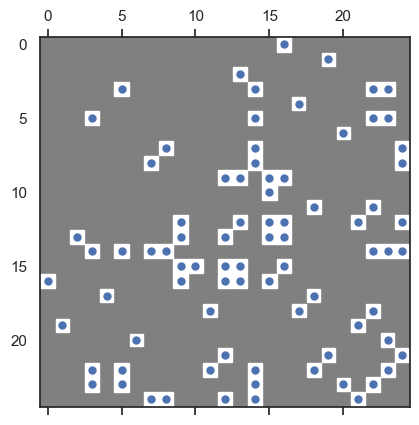

In [53]:
hinton(_sq(np.mean(X@np.linalg.solve(np.eye(n_authors)+5*L, np.abs(fullB.T)), axis=0)))
# plt.spy((lambda a: a-_diag(a))( _outer(np.multiply, X[1])), marker='x', color='r')
plt.spy(A, marker='.')

/tmp/ipykernel_4092138/510755441.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xsol,resid,_,_ = np.linalg.lstsq(np.abs(fullB), edge_X.T)


[Text(0.5, 1.0, 'OLS projection')]

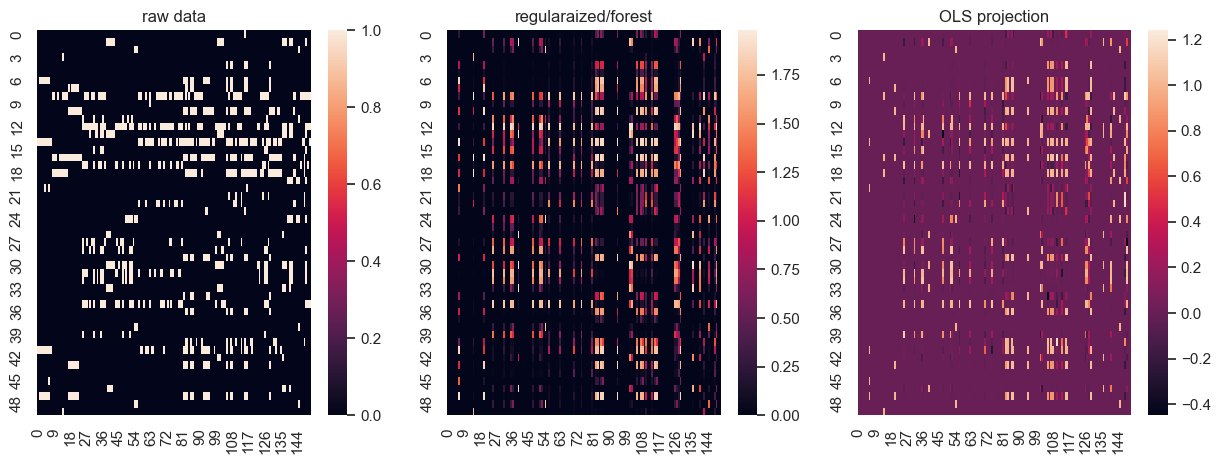

In [54]:
mask = edge_X.sum(axis=0)>1
f,ax = plt.subplots(ncols=3, figsize=(15,5))

sns.heatmap((X@(np.linalg.solve((np.eye(n_authors)+0.5*L)*2., np.abs(fullB.T))))[:,mask], ax=ax[1])
sns.heatmap((edge_X)[:,mask], ax=ax[0])

Xsol,resid,_,_ = np.linalg.lstsq(np.abs(fullB), edge_X.T)
edge_pred=(np.abs(fullB)@Xsol).T
edge_pred[np.isclose(edge_pred, np.zeros_like(edge_pred))] = 0
# sns.heatmap((X@(np.linalg.pinv(fullB)@np.abs(fullB.T)))[:,mask], ax=ax[2])
sns.heatmap(edge_pred[:,mask], ax=ax[2])
ax[1].set(title='regularaized/forest')
ax[0].set(title='raw data')
ax[2].set(title='OLS projection')

<Axes: >

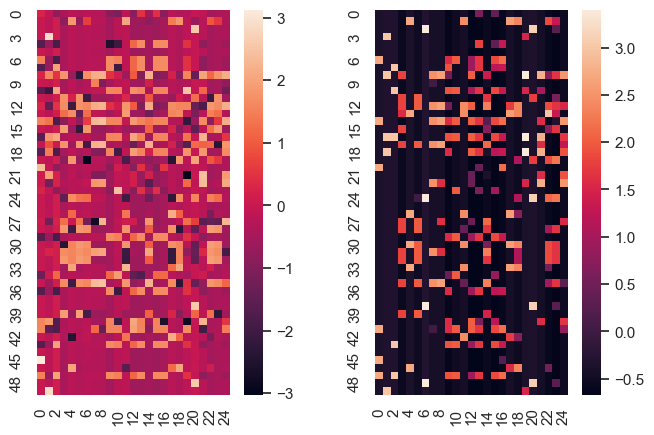

In [55]:
f,ax = plt.subplots(ncols=2, figsize=(8,5))

sns.heatmap((lambda a: (a-a.mean(axis=0))/np.std(a, axis=0))(Xsol.T), square=True, ax=ax[0])
sns.heatmap((lambda a: (a-a.mean(axis=0))/np.std(a, axis=0))(X_est),
            square=True, ax=ax[1])
# (lambda a: (a-a.mean(axis=0))/np.std(a, axis=0))(X_est.todense()).mean(axis=0)

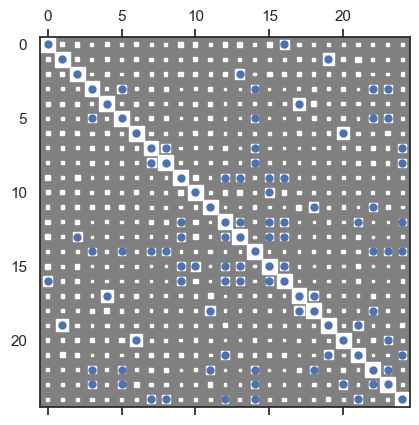

In [56]:
# sns.heatmap(np.linalg.solve(np.eye(n_authors)+1*L, np.abs(fullB.T))[:,mask].T)
hinton(ochiai(np.linalg.solve((np.eye(n_authors)+0.1*L)*2., np.abs(fullB.T)).T, pseudocts=0.1))
plt.spy(L, marker='.')

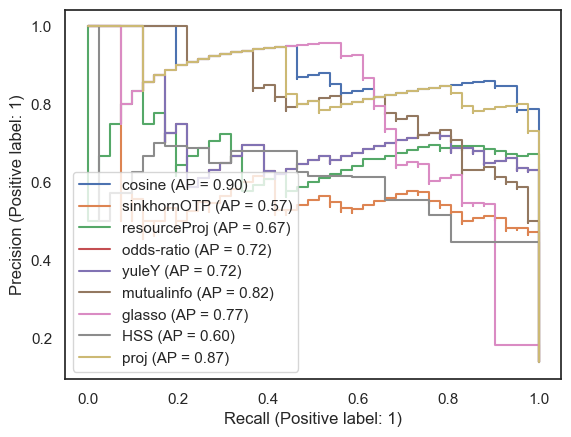

In [57]:
for lab,Aest in baselines.items():
    PrecisionRecallDisplay.from_predictions(true, Aest, name=lab, ax=plt.gca())    

PrecisionRecallDisplay.from_predictions(true,_sq(ochiai((np.linalg.solve((np.eye(n_authors)+0.01*L)*2., np.abs(X.T)).T))),name='proj', ax=plt.gca())

<Axes: >

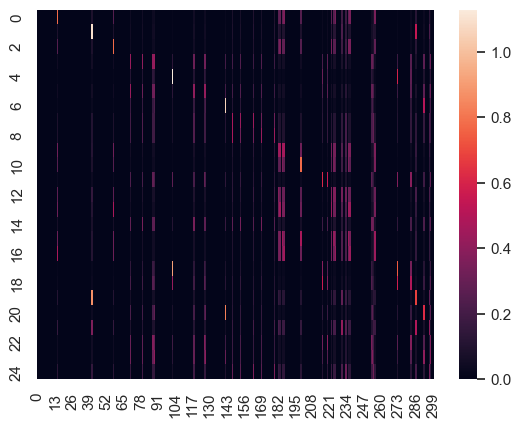

In [58]:
from sklearn.decomposition import NMF
from sklearn.linear_model import MultiTaskLasso
from sklearn.kernel_ridge import KernelRidge

# model = NMF(n_components=n_authors, alpha_W=0.001).fit(edge_X[:,mask])
# model = MultiTaskLasso(alpha=0.05, fit_intercept=False).fit(X = np.abs(fullB).T, y = edge_X)
model = KernelRidge(alpha=1, kernel='precomputed').fit(fullB.T@fullB, np.abs(fullB).T)
sns.heatmap(model.dual_coef_)

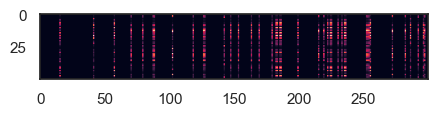

In [59]:
plt.figure(figsize=(5,10))
plt.imshow(model.predict(X))
# plt.spy(X, marker='x')

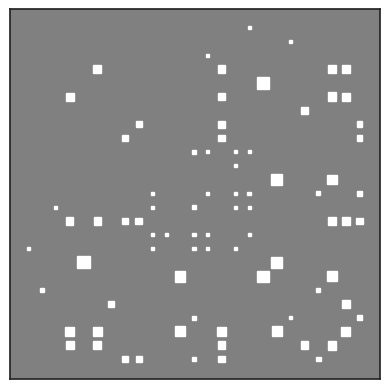

In [60]:
hinton(_sq(model.predict(X)[1]))

array([0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       1.01791759, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 1.01609438, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 1.01609438, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       0.03912023, 0.03912023, 0.03912023, 0.03912023, 0.03912023,
       1.10464773, 0.03912023, 0.03912023, 0.03912023, 0.03912

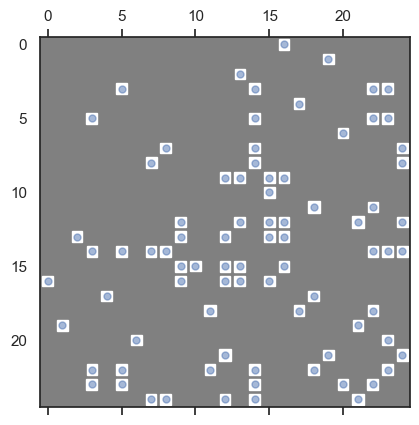

In [61]:
from scipy.special import logsumexp
# hinton(squareform(edge_pred[0]))
# hinton(_sq(logsumexp(1000*edge_pred,axis=0)/1000))

hinton(_sq(np.max(edge_pred,axis=0)))
plt.spy(A, marker='.', alpha=0.5)
logsumexp(100*edge_pred,axis=0)/100

In [62]:
resid

array([ 0.50703135,  9.57243749,  1.        ,  0.        ,  0.25312863,
        0.        ,  9.25312863,  4.25312863, 48.8041113 ,  0.50535415,
       22.22792758,  3.56895884, 56.56328216, 13.59829795, 56.59829795,
        0.62606975, 38.22792758, 15.49318368, 29.50535415,  3.57243749,
        1.50703135,  2.78635015,  8.62297338,  1.50703135,  9.59829795,
        0.        ,  3.24057111,  8.82315782,  4.35694319,  4.25312863,
       17.35694319, 14.22792758,  4.35694319,  5.24057111,  2.56328216,
       19.22792758,  0.25312863,  0.        ,  1.        ,  0.62606975,
        6.22792758, 22.40429192,  1.24057111,  9.25312863,  0.        ,
        0.        ,  3.24057111, 15.25312863,  1.        ,  0.        ])

In [63]:
from scipy.stats import gumbel_r
gumbel_r.rvs(smooth_pmf)

array([ 7.94666568e-01,  1.53020143e+00, -1.29587040e+00,  2.40620901e+00,
       -3.86702110e-01,  3.23094386e+00,  9.76605427e-01,  3.30370680e+00,
        2.11616364e+00,  2.81970504e+00,  1.70839079e+00, -8.01001493e-03,
       -6.28178744e-01,  2.06275481e+00,  1.28194934e+00,  5.06307431e-01,
        7.18693110e-01,  1.75518252e-01,  8.55693759e-01,  1.93391696e+00,
        2.14134259e-01,  7.23289863e-01,  2.23081639e-01,  3.61548700e-01,
        3.85977670e-01, -6.36558209e-01,  1.98907145e+00,  9.30033374e-01,
        8.57452603e-01,  2.79181535e+00,  7.46193992e-01,  1.28098872e+00,
        8.09770306e-01,  2.28128251e-01,  1.35610148e+00,  1.77948393e+00,
        4.33774663e+00, -4.45351978e-01,  1.43892047e+00, -3.07567329e-01,
        1.36923994e+00,  2.40950374e+00,  9.22669351e-01, -7.24306525e-01,
        7.08355544e-01, -8.80756894e-01,  4.44194265e+00,  1.84438298e+00,
        3.07001776e-01,  1.73716227e+00,  9.58290324e-01, -2.40454113e-01,
        1.59610427e+00,  

In [64]:
def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        
    for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_x = data_x[-1]
        right_most_y = data_y[-1]
        ax.annotate(
            line.get_label(),
            xy=(right_most_x, right_most_y),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            color=line.get_color(),
        )
    ax.legend().set_visible(False)

In [65]:
def binary_hellinger(a,b):
    return np.sqrt(1-(np.sqrt(a*b)+np.sqrt((1-a)*(1-b))))
# (1-(np.sqrt(true*_sq(post_L))+np.sqrt((1-true)*_sq(1-post_L)))).mean(), 
binary_hellinger(true, _sq(post_L)).mean(), binary_hellinger(true, mst_post).mean()

(0.10812595413684534, 0.13139788326615362)

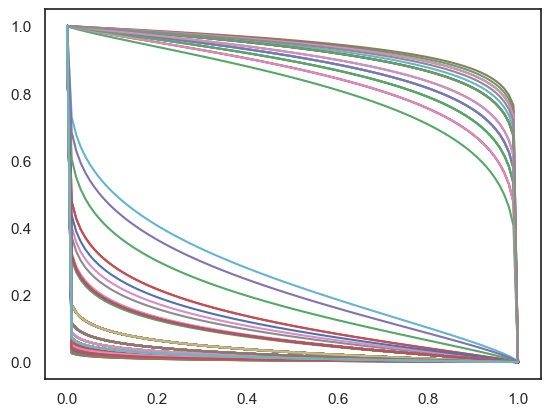

In [67]:
from scipy import stats #import binom, bernoulli, beta

# binom_jeff(10,2)(0.8)
# beta.cdf([0,0.5,1],a=[1,2,3],b=[1,2,3])

from affinis.priors import pseudocount


cts = _sq(X.T@X)
x = np.linspace(0,1, num=100)
a,b = (2/n_authors, 1-2/n_authors)
# a,b = (1/2, 1/2)

c = E_obs.sum(axis=0)
c = (c-a*cts)/(cts+1)

a_n = a + c
# b_n = b + cts - c
b_n = 1-a_n

# sum to 1
# a_n = (c-a*cts)/(cts+1)
# a_n = (cts/(cts+1))*(c/cts-a)
# b_n = 1 - a_n
## same as
# a_n = a_n/(a_n+b_n)
# b_n = 1-a_n

# # norm to max (beta process)
# a_n = a_n/np.maximum(a_n, b_n)
# b_n = b_n/np.maximum(a_n, b_n)
posterior_p = stats.beta.sf(
    # baselines['cosine'][...,None],
    x[...,None],
    a_n,
    b_n,
)
plt.plot(x, posterior_p);
# stats.beta.mean(
#     # baselines['cosine'][...,None],
#     # x[...,None],
#     a_n,
#     b_n,
# )
# posterior_p[95].round(3)
# np.around(pseudocount('min-connect')(E_obs.sum(axis=0), cts), decimals=3)

		 E[F_0.5]	 E[MCC] 	 E[Hell. Cost] 	 Avg P
cosine    	      0.54	      0.48	      8.97	      0.90
sinkhornOTP	      0.24	      0.23	     13.99	      0.57
resourceProj	      0.43	      0.36	     11.60	      0.67
odds-ratio	      0.35	      0.29	     14.17	      0.72
yuleY     	      0.47	      0.42	      8.43	      0.72
mutualinfo	      0.46	      0.42	     11.92	      0.82
glasso    	      0.43	      0.35	     12.44	      0.77
HSS       	      0.42	      0.35	     11.65	      0.60
MST_e     	      0.74	      0.61	      6.77	      0.72
MST_i     	      0.63	      0.52	     10.23	      0.94


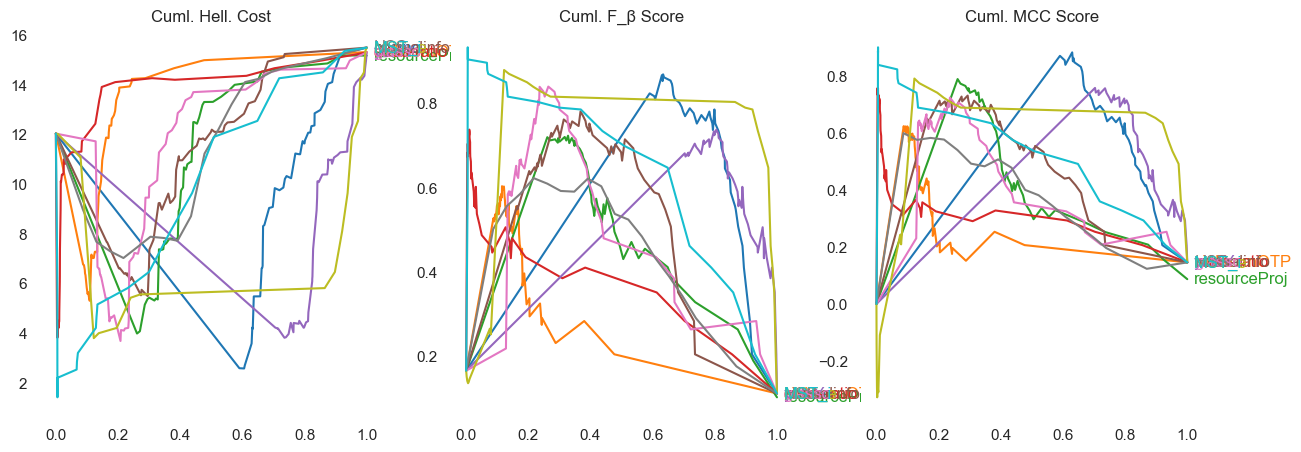

In [78]:
# plt.plot(r,p, color='r', ls=':', zorder=0, alpha=0.5, label='pure cosine')
# plt.plot(r,p, color='g', ls=':', zorder=0, alpha=0.5, label='Sinkhorn OT')
from sklearn.metrics import matthews_corrcoef, average_precision_score, fbeta_score
from scipy.spatial.distance import jensenshannon
# from scipy.stats import entropy, iqr
from toolz import juxt
# from affinis.utils import edge_mask_to_laplacian
# from scipy.stats import multivariate_normal, beta
from scipy import stats
from scipy.interpolate import interp1d
def zscore(x):
    return (x-x.mean())/x.std()
def thres_expect(dist, x_thres, score):
    return dist.expect(interp1d(x_thres,score, bounds_error=False, kind='next'))
def human_thres_expect(x_thres, score):
    # return 0.5*thres_expect(stats.beta(0.5,0.5),x_thres, score)+0.5*thres_expect(stats.beta(2.5,1.7),x_thres,score)
    # return thres_expect(stats.beta(2.5,1.7), x_thres,score)
    return trapezoid(score, x=x_thres)
from scipy.linalg import sqrtm

def wasserstein_gaussian(C1, C2):
    a = np.trace(C1+C2)
    sqrtC1 = sqrtm(C1)
    b = np.trace(sqrtm(sqrtC1@C2@sqrtC1))
    # print(a,b)
    return a - 2*b

def bhattacharyya(a,b):
    return np.sqrt(a*b).sum(axis=0)
def hellinger(a,b): 
    return np.sqrt(1-bhattacharyya(a,b))

def weights_to_laplacian(w): 
    A = _sq(w)
    return np.diag(A.sum(axis=0)) - A

baselines['MST_e'] = _sq(SFD_edge_cond_prob(X, pseudocts=psct))
# baselines['MST_e'] = posterior_p[50]
# baselines['MST_e'] = stats.beta.mean(a_n,b_n)

baselines['MST_i'] = _sq(SFD_interaction_prob(X, pseudocts=psct))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,5))
# fig.add_subplot(
cmap = plt.get_cmap("tab10")

color_cyc = cycler(color=[cmap(i) for i in range(len(baselines))])
cyc =  color_cyc*cycler(linestyle=['-','--'])
ax1.set_prop_cycle(cyc)
# ax0.set_prop_cycle(color_cyc)

beta = 0.5
print(f'\t\t E[F_{beta}]\t E[MCC] \t E[Hell. Cost] \t Avg P'.format(':>20'))

for n,(lab,Aest) in enumerate(baselines.items()):
    p,r,t = precision_recall_curve(true, Aest, drop_intermediate=True)
    
    # ax0.plot(r,p, label=lab, lw=2)
    
    # PrecisionRecallDisplay.from_predictions(true, Aest, name=lab, ax=ax0)    
    # ax1.plot(minmax(t),np.array([p[:-1],r[:-1]]).T, lw=2, label='precision', alpha=0.2)
    x_thres = np.append(minmax(t), 1.01)
    A_thres = [(minmax(Aest)>=i).astype(int) for i in x_thres]
    
    mcorr = [matthews_corrcoef(true, est) for est in A_thres]
    
    F = forest(L)
    # try: 
    AestForest = [forest(weights_to_laplacian(est)) for est in A_thres ]
    # except ValueError: 
    #     AestForest = [sinkhorn(np.linalg.pinv(weights_to_laplacian(est))) for est in A_thres]
    # kldiv = [stats.entropy(F,fthres).sum() for fthres in AestForest]
    hell = [hellinger(F,fthres).sum() for fthres in AestForest]
    print(
        f'{lab:<10}'
        f'\t{human_thres_expect(x_thres, f_beta(beta,p,r)):>10.2f}'
        f'\t{human_thres_expect(x_thres, mcorr):>10.2f}'
        # f'\t{np.sqrt(np.dot(true-minmax(Aest), true-minmax(Aest))):>10.2f}'
        # f'\t{binary_hellinger(true, minmax(Aest)).mean():>10.2f}'
        # f'\t{human_thres_expect(x_thres, kldiv):>10.2f}'
        f'\t{human_thres_expect(x_thres, hell):>10.2f}'
        f'\t{average_precision_score(true, Aest):>10.2f}'
    )
    ax0.set_title('Cuml. Hell. Cost')
    ax1.set_title('Cuml. F_β Score')
    ax2.set_title('Cuml. MCC Score')
    ax0.plot(x_thres[:-1], np.array(hell)[:-1], color=cmap(n), ls='-', label=lab)
    ax1.plot(x_thres[:-1], f_beta(beta, p,r)[:-1], color=cmap(n), ls='-', label=lab)
    ax2.plot(x_thres[:-1], mcorr[:-1], color=cmap(n), ls='-', label=lab)
    # ax0.plot(x_thres, cumulative_trapezoid(np.array(hell), x=x_thres, initial=0.), 
    #          color=cmap(n), ls='-', label=lab)
    # ax1.plot(x_thres, cumulative_trapezoid(f_beta(beta, p,r), x=x_thres, initial=0.), 
    #          color=cmap(n), ls='-', label=lab)
    # ax2.plot(x_thres, cumulative_trapezoid(mcorr, x=x_thres, initial=0.), 
    #          color=cmap(n), ls='-', label=lab)
    

improve_legend(ax0)
improve_legend(ax1)
improve_legend(ax2)

In [74]:
from affinis.filter import min_connected_filter
from toolz import valmap
eps = 1e-4*np.random.rand(baselines['cosine'].shape[0])
baselines_mcf = valmap(lambda x: ~min_connected_filter(x).mask, baselines)
for lab,est in baselines_mcf.items():
    # MCF = min_connected_filter(est+eps)
    estForest = forest(weights_to_laplacian(est.astype(int)), beta=1)
    kldiv = stats.entropy(forest(L, beta=1), estForest)
    bk = bhattacharyya(forest(L), estForest)
    wOT = wasserstein_gaussian(np.linalg.pinv(L),np.linalg.pinv(weights_to_laplacian(est.astype(int))))
    print(
        f'{lab:<10}', 
        f'\t{fbeta_score(true, est, beta=0.5):>10.2f}'
        f'\t{kldiv.sum():>10.2f}'#+/- {kldiv.std()*kldiv.shape[0]:.2f}'
        f'\t{np.sqrt(1-bk).sum():>10.2f}'
    ) 
# weights_to_laplacian(est.astype(int))

cosine     	      0.81	      1.41	      2.70
sinkhornOTP 	      0.58	      6.16	      5.86
resourceProj 	      0.71	      2.84	      4.07
odds-ratio 	      0.72	      4.92	      4.83
yuleY      	      0.72	      4.92	      4.83
mutualinfo 	      0.74	      5.19	      5.49
glasso     	      0.80	      4.15	      4.48
HSS        	      0.59	     10.39	      7.83
MST_e      	      0.82	      7.28	      5.55
MST_i      	      0.82	      6.22	      5.15


<Axes: >

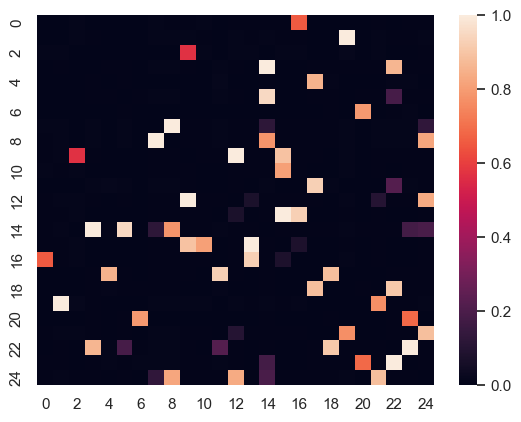

In [75]:
# sns.heatmap(_sq((E_obs.sum(axis=0)+0.5)*_sq(coocur_prob(X))/(cts+1) + (1-(E_obs.sum(axis=0)+0.5)/(cts+1))*(1-_sq(coocur_prob(X)))))

sns.heatmap(SFD_edge_prob(X, pseudocts=psct))

In [76]:
from scipy import stats #import binom, bernoulli, beta
from scipy.integrate import quad
# trapezoid()
# bernoulli(0.6).pmf(np.array([0,1,1,0])).prod()
# binom(4, 0.6).pmf(2)
def binom_jeff(n,s): 
    # b = np.beta(s+0.5, n-s+0.5)
    def Ppost(p): 
        return p**(s-0.5)*(1-p)**(n-s-0.5)/b.pdf(p)
    return Ppost
# m1,tol = quad(binom_jeff(10,1),0,1)
# beta(2+0.5, 4-2+0.5).pdf(0.6)
# binom(10,0.6).pmf(1)/m1
np.random.binomial(np.arange(10), 0.5)

array([0, 0, 1, 2, 1, 3, 3, 3, 6, 4])

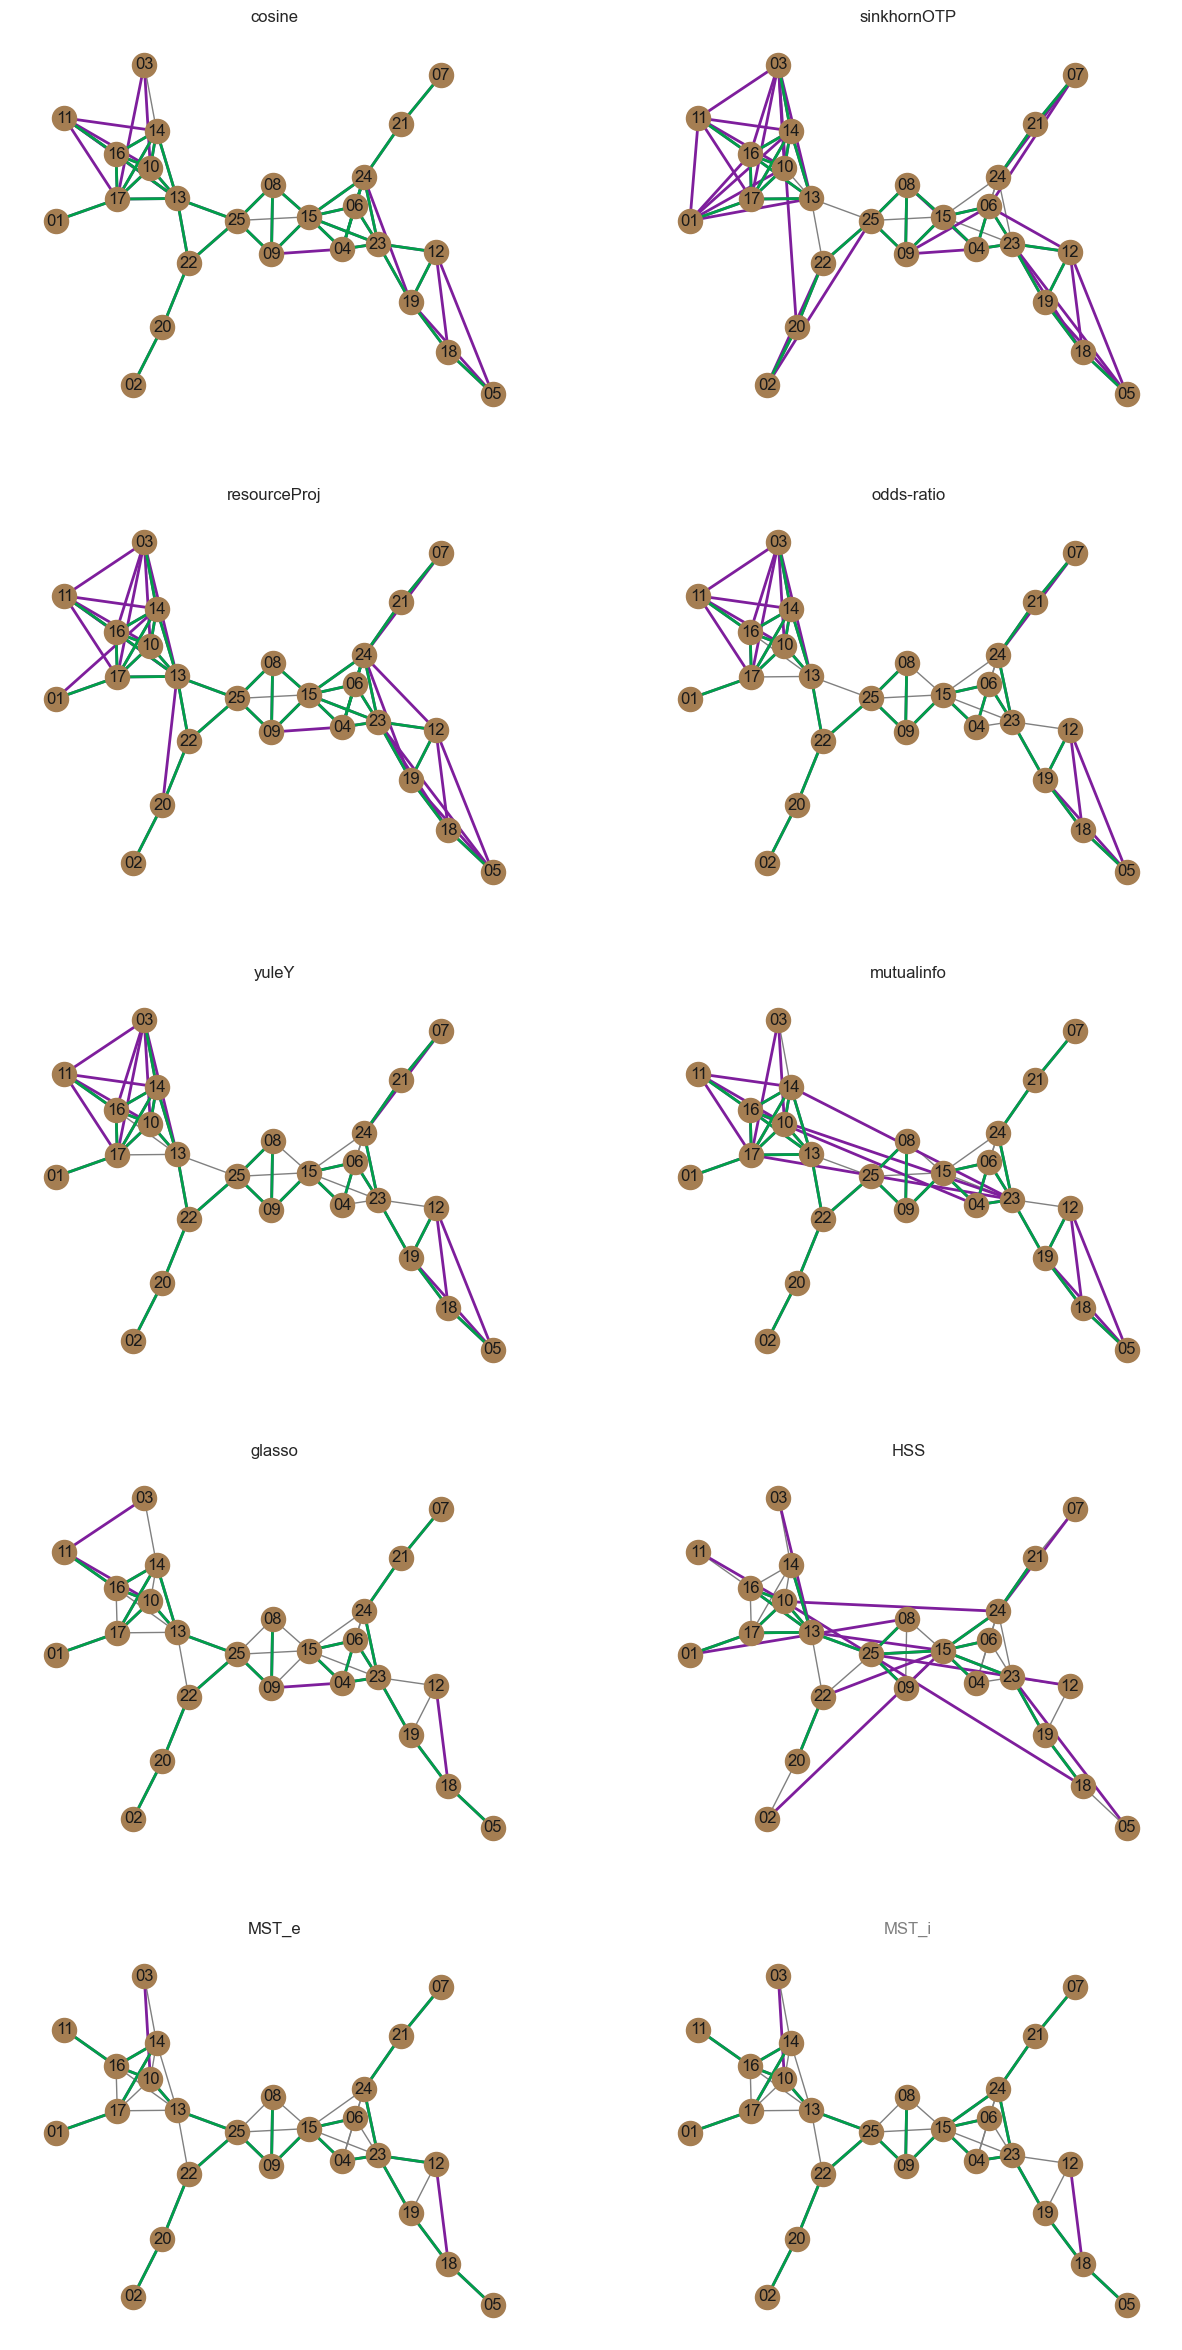

In [77]:
# Aest = _sq(baselines_mcf['MST_i'])
# thres_lim = 0.3
f,ax = plt.subplots(nrows=5,ncols=2, figsize=(15,30))

for n, (lab, E_est) in enumerate(baselines_mcf.items()):
    draw_G(G, ax=ax.flatten()[n])
    ax.flatten()[n].set_title(lab)
    Aest = _sq(E_est)
    nx.draw_networkx_edges(
        nx.from_pandas_adjacency(
            pd.DataFrame(Aest*_sq(_sq(~A)), columns=author_idx, index=author_idx)
        ), 
        edge_color='xkcd:purple', width=2,
        pos=pos, ax=ax.flatten()[n]
    )
    nx.draw_networkx_edges(
        nx.from_pandas_adjacency(
            pd.DataFrame(Aest*_sq(_sq(A)), columns=author_idx, index=author_idx)
        ), edge_color='xkcd:emerald', width=2,
        pos=pos, ax=ax.flatten()[n]
    )

    # nx.draw_networkx_edges(
    #     nx.from_pandas_adjacency(
    #         pd.DataFrame(~Aest*_sq(_sq(A)), columns=author_idx, index=author_idx)
    #     ), edge_color='xkcd:orange', pos=pos, ax=ax.flatten()[n]
    # )

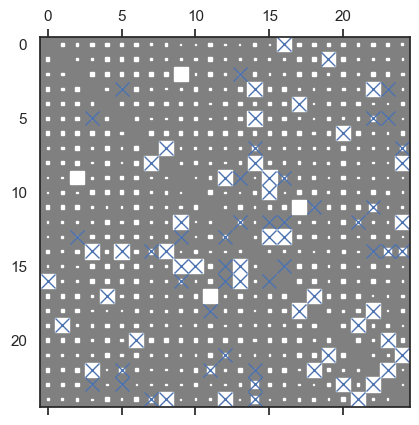

In [128]:
# stats.beta.std(
#     # baselines['cosine'][...,None],
#     # x[...,None],
#     a_n,
#     b_n,
# ).sum()
hinton(_sq(posterior_p[50]))
plt.spy(A, marker='x')

In [126]:
from scipy.special import beta, digamma
def kl_beta(a1, b1, a2, b2):
  """https://en.wikipedia.org/wiki/Beta_distribution"""
  B = beta
  DG = digamma
  return np.log(B(a2, b2) / B(a1, b1)) + (a1 - a2) * DG(a1) + (b1 - b2) * DG(b1) + (
        a2 - a1 + b2 - b1) * DG(a1 + b1)

kl_beta((E_obs.sum(axis=0)+0.5), 0.5, (cts - E_obs.sum(axis=0) + 0.5), 0.5)[cts>3].argmin()

82

In [127]:
np.array([(E_obs.sum(axis=0)+0.5),(cts - E_obs.sum(axis=0) + 0.5)]).T[82]

array([0.5, 2.5])

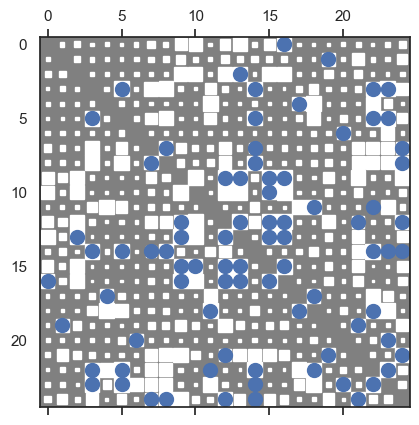

In [125]:
from scipy.special import beta as Beta

# marginal likelihood from beta binom
a_n = (E_obs.sum(axis=0)+0.5)
b_n = (cts - E_obs.sum(axis=0) + 0.5)
marg1=Beta(a_n,b_n)/Beta(0.5,0.5)  # jeffreys


# likelihood based on point-estimate
marg2=stats.binom.pmf(
    E_obs.sum(axis=0),
    cts,
    baselines['cosine']
    
)
post_prob = (lambda o: o/(o+1))((lambda p: p/(1-p))(baselines['cosine'])*(marg1/marg2))
# sns.histplot(marg1/marg2)
hinton(_sq(post_prob))
plt.spy(A, marker='o')

In [138]:
p_x_lab

array([0.5       , 0.25      , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.16666667, 0.25      , 0.1       , 0.1       ,
       0.5       , 0.1       , 0.08333333, 0.25      , 0.1       ,
       0.92857143, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.25      , 0.5       , 0.25      , 0.16666667, 0.25      ,
       0.25      , 0.5       , 0.5       , 0.5       , 0.25      ,
       0.25      , 0.125     , 0.25      , 0.5       , 0.125     ,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.5       ,
       0.5       , 0.91666667, 0.5       , 0.125     , 0.25      ,
       0.25      , 0.125     , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.91666667, 0.1       ,
       0.5       , 0.08333333, 0.08333333, 0.5       , 0.08333333,
       0.08333333, 0.5       , 0.5       , 0.16666667, 0.5       ,
       0.16666667, 0.5       , 0.5       , 0.25      , 0.25      ,
       0.05      , 0.5       , 0.08333333, 0.07142857, 0.16666

In [337]:
# sns.heatmap(np.eye(n_authors) - _norm_diag(L))
# sns.heatmap(sinkhorn(Asym))
_sq(Asym)

def jaccard_probability(x,y):
    # Ignore  == 0 terms
    x0 = x#[x!=0]
    y0 = y#[y!=0]
    
    jac = np.sum(
        1.0 / np.sum(np.ma.maximum(np.ma.divide(x0[:,None], x0), np.ma.divide(y0[:,None], y0)), axis=0)
        )
    
    return jac

jaccard_probability(_sq(A), baselines['cosine'])

0.3424487005936516

In [335]:
wasserstein_gaussian(np.linalg.pinv(L),np.linalg.pinv(weights_to_laplacian(baselines[''])))

# sqrtm(forest(L, beta=5))

26.68086643751655 (4.038164596404959+5.739242019797064j)


(18.60453724470663-11.478484039594129j)

In [358]:
juxt([np.sum, np.median, iqr])(entropy(forest(L), forest(weights_to_laplacian(baselines['MST_e']))))

(6.519527992931595, 0.262913773439824, 0.11889390397148847)

In [248]:
Asym = np.eye(n_authors) - _norm_diag(L)
# sns.heatmap(Asym/_outer(np.multiply, np.sqrt(Asym.max(axis=0))))
Acosinv = np.ma.masked_less_equal(np.round(np.eye(n_authors) - np.ma.divide(1,_norm_diag(L)),5), 0)
Acosinv.min(axis=0)

masked_array(data=[2.23607, 1.41421, 2.23607, 4.0, 1.41421, 4.0, 1.41421,
                   3.0, 3.0, 4.47214, 2.23607, 2.44949, 4.24264, 2.23607,
                   4.58258, 2.23607, 2.23607, 1.41421, 2.44949, 1.41421,
                   1.41421, 2.44949, 3.4641, 3.16228, 3.87298],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False],
       fill_value=1e+20)

<BarContainer object of 25 artists>

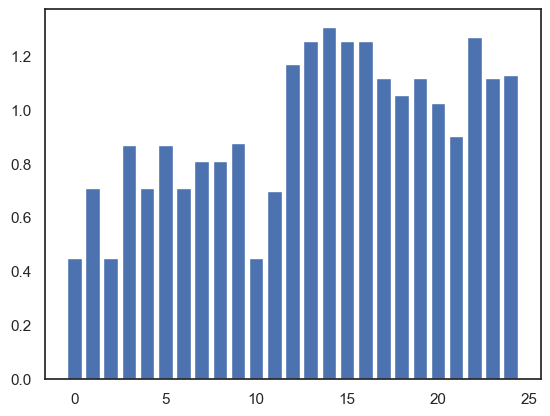

In [285]:
A/_outer(np.multiply,np.sqrt(A.sum(axis=0)))

pca = np.linalg.eigh(Acosinv.filled(0))
# sns.heatmap(Asym*pca.eigenvalues[-1]*_outer(np.multiply, pca.eigenvectors[:,-1]))
plt.bar(np.arange(n_authors), Asym.sum(axis=0))

<BarContainer object of 25 artists>

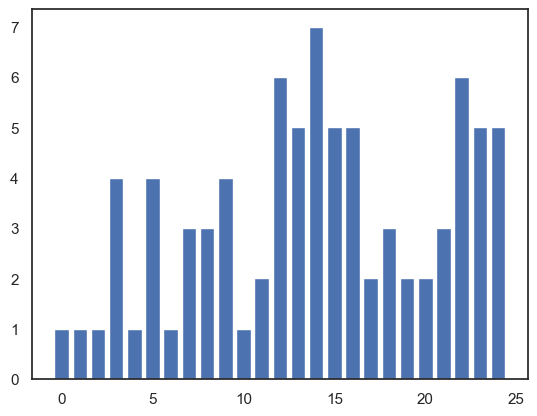

In [286]:
plt.bar(np.arange(n_authors), A.sum(axis=0))

<Axes: >

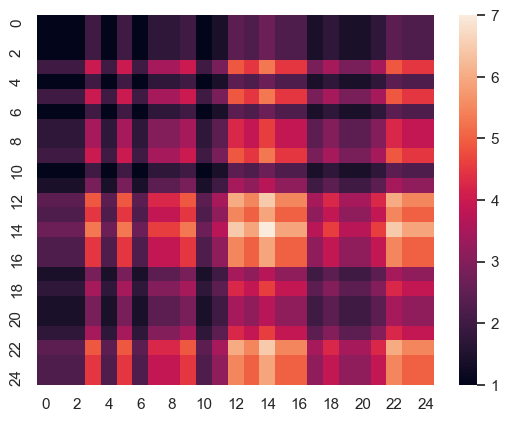

In [278]:
# _outer(np.multiply,Acosinv.sum(axis=0)/2)
sns.heatmap(_outer(np.multiply, np.sqrt(A.sum(axis=0))))

<Axes: >

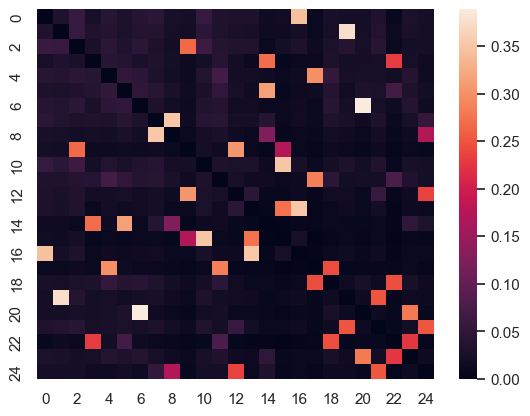

In [169]:
sns.heatmap(sinkhorn(_sq(baselines['MST_i'])))

<Axes: >

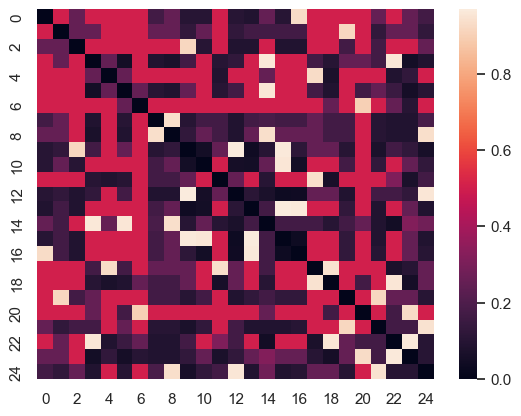

In [150]:
# a_n/(a_n+b_n)
# sns.histplot(marg1/marg2)

N_unlab = X.shape[0] - cts
p_x_lab = (E_obs.sum(axis=0)+0.5)/(cts+1)
p_lab = _sq(coocur_prob(X))
p_x_unlab = (N_unlab - p_lab*p_x_lab*N_unlab)/(N_unlab*(1-p_lab))-1

# sns.heatmap(_sq(p_x_unlab))
sns.heatmap(_sq(p_x_lab))

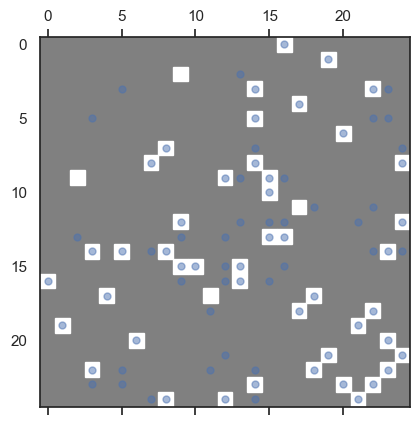

In [85]:
hinton(_sq(baselines_mcf['MST_i']))

plt.spy(A, marker='.', alpha=0.5)

<Axes: >

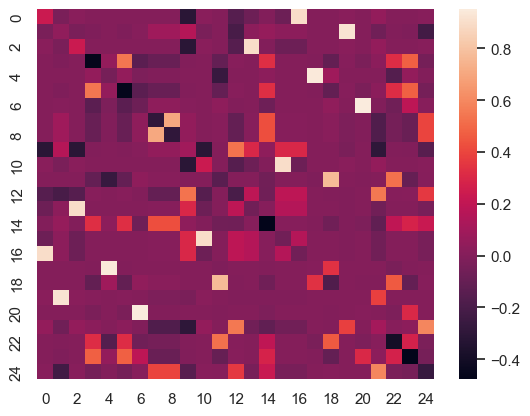

In [78]:
# sns.heatmap((lambda a: _norm_diag(np.ma.log((1+a)/(1-a)).filled(0)/2)-np.eye(n_authors))(forest(L, beta=10)))
SS = (1j*np.tril(L, k=-1) - 1j*np.tril(L, k=-1).T)
shuff = rng.choice(n_authors)
# sns.heatmap(_norm_diag(np.abs(np.real((np.eye(n_authors)-SS)@np.linalg.inv(np.eye(n_authors)+ SS)))))
# rng.permutation(SS)

# hinton(-(np.eye(n_authors)+np.imag((lambda a: (1-a)/(1+a))(1j*_norm_diag(forest(L))))))
# plt.spy(L, marker='.')

from scipy.linalg import polar

U,P = polar(np.eye(n_authors)-_norm_diag(L))

sns.heatmap(U)

<Axes: >

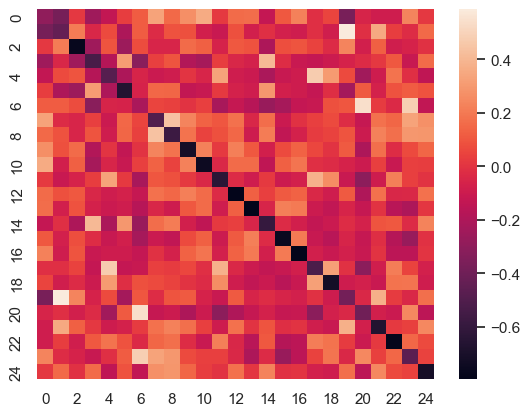

In [204]:
U,P = polar(yule_q(X, pseudocts=psct))
sns.heatmap(U)
# U

In [79]:
# hinton( 1-np.eye(n_authors) - (np.real((lambda a: (1-a)/(1+a))(1j*_norm_diag(forest(L))))))
# plt.spy(L, marker='.')

Bj = 1j*np.eye(n_authors)[coo_array(A).row] - 1j*np.eye(n_authors)[coo_array(A).col]
(Bj.T@Bj)/2

array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -4.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0

/home/tbsexton/.pyenv/versions/miniforge3/envs/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2912: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  lbc = integrate.quad(fun, lb, c, **kwds)[0]
/home/tbsexton/.pyenv/versions/miniforge3/envs/affinis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2913: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local dif

0.45064326744071503

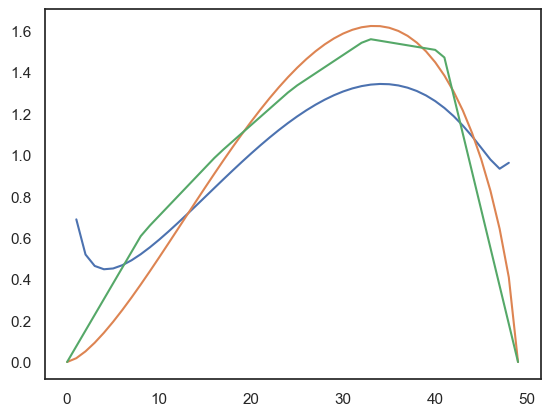

In [80]:
plt.plot(0.3*stats.beta(0.5,0.5).pdf(np.linspace(0,1))
         +0.7*stats.beta(2.5,1.7).pdf(np.linspace(0,1))
        )
plt.plot(stats.beta(2.5,1.7).pdf(np.linspace(0,1)))

# approximate, from this publication on star ratings: 
# https://www.emerald.com/insight/content/doi/10.1108/XJM-10-2020-0171/full/html

plt.plot(np.array([[0.1,1/25.,3/50.,0.2,3/5.][n]*stats.triang(i).pdf(np.linspace(0,1)) for n,i in enumerate(np.linspace(0,1,7)[1:-1])]).sum(axis=0))
np.array([[0.1,1/25.,3/50.,0.2,3/5.][n]*thres_expect(stats.triang(i),x_thres,mcorr) for n,i in enumerate([0.05,0.25,0.5,.75,0.95])]).sum()

# multivariate_normal(cov=forest(L, beta=5.)).logpdf(Xstack/2)  # for co-occurrences
# multivariate_normal(cov=_norm_diag(5*L+np.eye(n_authors))).logpdf(np.array(struct.todense())[:,:-1]).sum()  # for interractions
# multivariate_normal(mean=0.0*np.ones(n_authors), cov=_norm_diag(5.*L+np.eye(n_authors))).logpdf(np.eye(n_authors))#.sum()  # for interractions

# np.array(struct.todense())[:,:-1]
# plt.plot((np.linspace(0,1)), interp1d(x_thres,mcorr,bounds_error=False)(np.linspace(0,1)))
# multivariate_normal(cov=np.eye(n_authors)).logpdf(np.array(struct.todense())[:,:-1])

## EM Algorithm

gets stuck in local minimum pretty much immediately (nope)...now it loses just like gibbs)

don't forget to add back the "forest" part (i.e. MST with added reg. node.

In [103]:
# [(n,np.diag(t.L())[-1]) for n,t in enumerate(trees)]  # find where tree split stuff into two 

NameError: name 'struct' is not defined

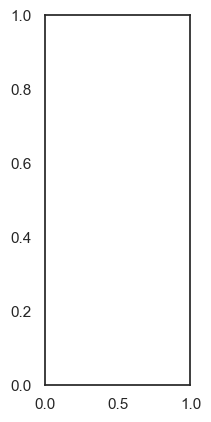

In [104]:
# hinton(adjusted_forest_dists(L))


# Ω=np.linalg.inv(L+np.ones_like(L)/n_authors**2)
# _prox_to_dists(Ω)
# sns.heatmap(1-adjusted_forest_dists(L))

def cond_on_root(cov, c_inv=None, root_loc=-1):
    if c_inv is None: 
        c_inv = np.linalg.pinv(cov)
    c_ir = np.delete(cov[root_loc], [root_loc])
    correction = outer(np.multiply, c_ir)*c_inv[root_loc,root_loc]
    return np.delete(np.delete(cov, root_loc, 1), root_loc, 0) - correction
plt.subplot(131)
hinton(forest(np.array((struct.T@struct).todense())))
plt.title('forest with root')
plt.subplot(132)
hinton(forest(_norm_diag(np.array((struct.T@struct).todense()))))
plt.title('normed-forest with root')
plt.subplot(133)
hinton(cond_on_root(forest(_norm_diag(np.array((struct.T@struct).todense())), beta=5.), c_inv=_norm_diag(np.array((struct.T@struct).todense()))))
plt.title('normed-forest|root')
# np.delete(np.delete((struct.T@struct).todense(),-1,0), -1,1).shape
# L[np.s_[[-1],[-1]]]
cond_on_root(forest(_norm_diag(np.array((struct.T@struct).todense())), beta=5.), c_inv=_norm_diag(np.array((struct.T@struct).todense()))).sum(axis=1)

In [105]:
## KINDA..."contracting"? the root node? into a longer edge connecting the two components. 
t=trees[14]
plt.subplot(131)
plt.title('with root')
hinton(t.L())
plt.subplot(132)
plt.title("marginal interractions")
hinton(t.L()[:-1,:-1])
print(np.round(trees[0].L()[:-1,:-1], 2))
plt.subplot(133)
plt.title("Interr. Cond. on root")
# hinton(cond_on_root(t.L()+np.eye(shp:=t.L().shape[0]), c_inv=np.linalg.inv(t.L()+np.ones((shp,shp))/shp**2)))
# print(np.round(cond_on_root(t.L()+np.eye(t.L().shape[0]), c_inv=forest(t.L(), beta=5.)), 2))

def adj_to_lap(A): 
    return np.diag(A.sum(axis=0))-A
hinton(adj_to_lap(-_sq(_sq(t.L()[:-1,:-1])-_sq(outer(np.multiply,t.L()[-1,:-1])*0.1))))
print(adj_to_lap(-_sq(_sq(t.L()[:-1,:-1])-_sq(outer(np.multiply,t.L()[-1,:-1])*0.1))))
1/(5+5)

NameError: name 'trees' is not defined

In [106]:
sns.heatmap(-(_sq(_sq(np.round(np.array((struct.T@struct).todense())/(Xdf.T@Xdf), 2).fillna(0).values)))[:-1,:-1])

NameError: name 'struct' is not defined

In [114]:
est_dists = bilinear_dists(sinkhorn(coocur_prob(X, pseudocts=psct)))

# B_obs = sprs.vstack([
#     (sparse_adj_to_incidence(minimum_spanning_tree(
#         get_mask(_sq(est_dists),i)
#     ))) for i in papers.values
# ])

# add_pmf = np.nan_to_num(_sq((np.abs(B_obs.T@B_obs).todense()+0.5)/(X.T@X+1.)))
# smooth_pmf = (add_pmf+np.where(add_pmf==0., 1, add_pmf))/(add_pmf.sum())
# smooth_pmf = (lambda odds: odds/(odds+1))(add_pmf/(1-add_pmf) +0.5)
# hinton(_sq(add_pmf))
# plt.spy(L, marker='x', alpha=0.6)
# smooth_pmf = _sq((np.abs(B_obs.T@B_obs).todense()+0.5)/(1+np.sqrt(_outer(np.multiply, X.sum(axis=0)))))
def edge_score_laplacian(E):
    A = -_sq(E)
    np.fill_diagonal(A,-A.sum(axis=0))
    return A


def M_step(data, expected_dists, expected_struct):
    B_obs = sprs.vstack([
        (sparse_adj_to_incidence(minimum_spanning_tree(
            get_mask(_sq(est_dists),i)
        ))) for i in data
    ])
    

    # smooth_pmf = _sq((np.abs(B_obs.T@B_obs).todense()+0.5)/(1+np.sqrt(_outer(np.multiply, data.sum(axis=0)))))
    # new_L = edge_score_laplacian(smooth_pmf)

    # B_obs = sprs.vstack(B_obs)#/len(B_obs)
    new_L = (B_obs.T@B_obs).todense()
    print(new_L.shape)
    # new_A = np.nan_to_num(np.abs(B_obs.T@B_obs).todense()/(data.T@data))
    return data, expected_dists, new_L

def E_step(data, expected_dists, expected_struct):

    trirow,tricol=np.triu_indices_from(expected_struct,k=1)
    fullB = np.multiply((np.eye(n_authors)[:,trirow] -np.eye(n_authors)[:,tricol]),np.abs(expected_struct)[trirow,tricol])
    Wproj = np.linalg.solve((np.eye(n_authors)+0.1*expected_struct)*2., np.abs(fullB))
    
    print(data.shape, Wproj.shape)
    Yproj = data@Wproj
    # new_dists = generalized_graph_dists(expected_struct, beta=5.)*_sq(_sq(-expected_struct))
    new_dists = 1-ochiai(Yproj.T, pseudocts=0.1)
    print(Yproj.shape, new_dists.shape)
    print(Yproj)
    # new_dists = np.exp(-mutual_information(expected_struct, pseudocts=1.))
    # print(new_dists)
    return data, new_dists, expected_struct

def EM(data, expected_dists, expected_struct): 
    X,Q,L = data, expected_dists, expected_struct
    while True: 
        X,Q,L = E_step(*M_step(X,Q,L))
        # yield Q,L
        # X,Q,L = E_step(X,Q,L)
        yield Q,L

(25, 25)
(50, 25) (25, 300)
(50, 300) (1, 50, 50, 50)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


ValueError: operands could not be broadcast together with shapes (25,25) (1,50,50,50) 

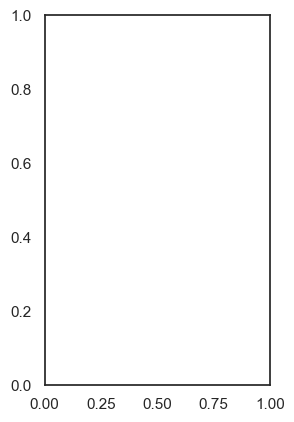

In [115]:
em_gen = EM(papers.values, est_dists, edge_score_laplacian(_sq(ochiai(X, pseudocts=psct))))
Q1,L1=next(em_gen)

plt.subplot(121)
hinton(L1/(1-Q1))
plt.spy(L, marker='.', alpha=0.4)
plt.subplot(122)
for i in range(100): 
    
    Qk,Lk=next(em_gen)
    # print(Qk)
    # print(multivariate_normal(cov=forest(Lk[:-1,:-1], beta=5.)).logpdf(Xstack/2).sum())
    # print(multivariate_normal(cov=forest(Lk[:-1,:-1], beta=5.)).entropy())
hinton(-_sq(_sq(Lk/(1-Qk))))
plt.spy(L, marker='x', alpha=0.4)

In [174]:
1-Qk

array([[1.        , 0.07043637, 0.07126117, 0.07604036, 0.07123718,
        0.07482243, 0.07486167, 0.06860205, 0.07092318, 0.12331799,
        0.07754644, 0.06733886, 0.07375002, 0.07343433, 0.06974415,
        0.07053989, 0.07033838, 0.07167345, 0.07256475, 0.07318051,
        0.07116441, 0.06979818, 0.07368304, 0.07558764, 0.06999029],
       [0.07043637, 1.        , 0.0661267 , 0.06973561, 0.06551364,
        0.06917394, 0.06909654, 0.11170125, 0.06555842, 0.06420194,
        0.06771536, 0.0623356 , 0.06772637, 0.06740011, 0.06404698,
        0.06515506, 0.06504172, 0.06620775, 0.06671025, 0.0668726 ,
        0.06564733, 0.0646082 , 0.06778869, 0.06540187, 0.06992864],
       [0.07126117, 0.0661267 , 1.        , 0.07039202, 0.06601129,
        0.06983756, 0.06970896, 0.06770395, 0.06596665, 0.06467319,
        0.06847746, 0.0624694 , 0.06848257, 0.06810578, 0.06461442,
        0.06630509, 0.06537067, 0.06668986, 0.06745815, 0.06763632,
        0.0765497 , 0.15220856, 0.06852209, 0.

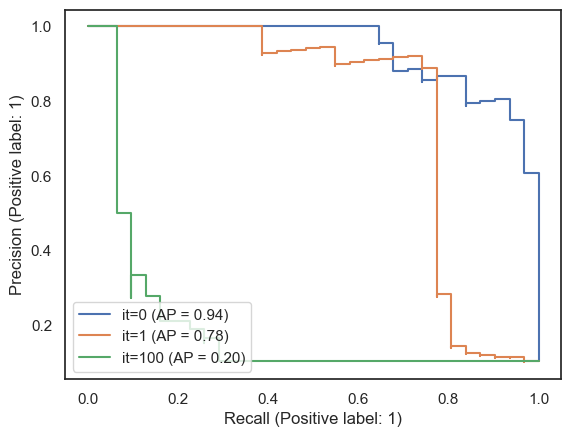

In [185]:
ochiai_struct = edge_score_laplacian(_sq(ochiai(X, pseudocts=psct)))
PrecisionRecallDisplay.from_predictions(true,-_sq(ochiai_struct), name='it=0')
em_gen = EM(papers.values, est_dists, ochiai_struct)
PrecisionRecallDisplay.from_predictions(true,-_sq(L1/(1-Q1)), name='it=1', ax=plt.gca())
for i in range(10): 
    Qk,Lk=next(em_gen)
PrecisionRecallDisplay.from_predictions(true,_sq(-Lk/ochiai_struct), name='it=100', ax=plt.gca())

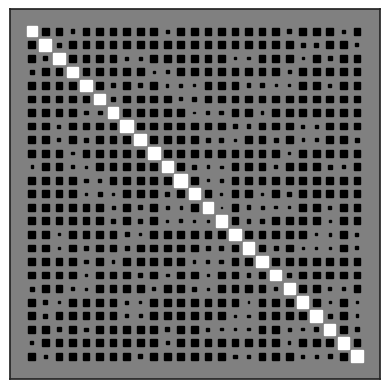

In [59]:
hinton((next(em_gen)[1])/(ochiai(X, pseudocts=psct)))

In [ ]:
# plt.spy(L, marker='.', alpha=0.4)

we can actually interpret ochiai/cosine as an approximate bayes update. 

Say we observe binary variables A and B, along with others. 

Now, we want a probability of conditional dependence between A and B (does information flow directly between a and b when a and b happen together?). So we want the probability ofand edge $E_{ab}$ being used, given that such an edge had the opportunity to be used. E.g. did two people have a causal interraction to make each other sick, given a time when we know they were both exposed/became sick. 

P(E|O) = P(O|E) * P(E)/P(O)

The denominator is hard, because while we can estimate the frequency of each node as the occurrences/opportunities (i.e. events/exposure), so, n_i/N, we can't use that for an exposure for "number of times an edge between A,B could have been used". If we multiply N(a)\*N(b), then we have the number of _ways_ a or b could be related over all chances, but this won't be a fraction of the number of samples, and could possible be much bigger... so dividing the number of times both _did_ happen together by that number won't get us a probability.  So instead, we fib a bit. 

The number of chances (out of all samples) that a pair had to happen together is somewhere between the chances each had separately. We make a pseudo-variable that uses this fact, but averaging the rates. but we are dealing with probabilities, which are based around "areas" and their ratios. So we want one count, such that watching it with a copy of itself has the same exposure as watching A and B separately. This is exaclty what geometric means are for: 


Then, a point estimate for the probability of an edge occurring is its actual co-ocurrence $n_{a,b}/N$. It's the ratio of  these that give us the Ochiai as a probability: divided by the estimate for the co-ocurrence opportunities

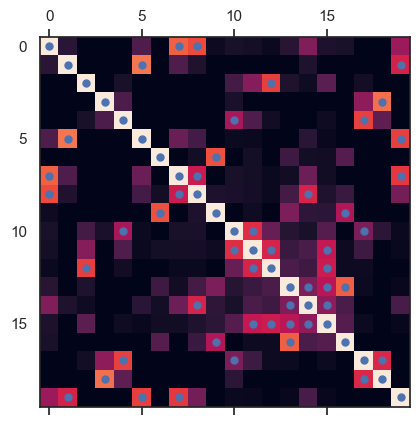

In [ ]:
# hinton(next(em_gen)[1])
# next(em_gen)[1]
# papers
# _squareform((papers.T@papers).values, checks=False)

def norm_pmf(x):
    return x/x.sum()
(_sq(_prox_to_dists((papers.T@papers).values)/papers.shape[0]))
# (_sq((papers.T@papers).values))/papers.shape[0]
# hinton(odds_ratio(papers).values)
# np.exp(papers.cov())
def indeps_over_actual(K):
    k_ii = np.diag(K)
    return K/np._sqrt(outer(np.multiply,k_ii))
    # return 
# np.multiply.outer(np.diag(papers.T@papers))
# plt.imshow(((lambda p: p/(1-p))(ochiai(papers.values))))
plt.spy(L, marker='.')
plt.imshow(np.exp(-_prox_to_dists(ochiai(papers.values))))
# 1-(_prox_to_dists(ochiai(papers.values)))

## Gibbs

need: 
- the individual tree estimates (mode is MST, resample with cut+bridge)
- individual trees' forest matrices --> the partition (bridge-possible) edges
- overall "structure" estimate (the edge-mixture model) --> bridge-probabilities

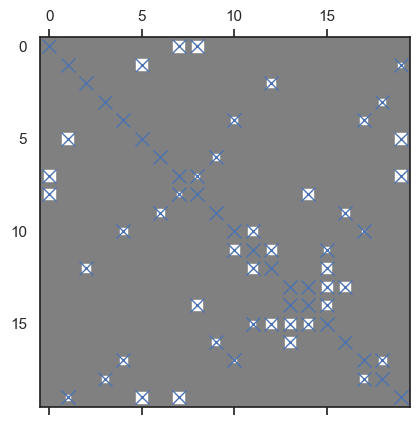

In [ ]:
# import static_frame as sf

from typing import NamedTuple
class TreeDistribution(NamedTuple):
    nodes: np.ndarray
    incidence: np.ndarray
    forest: np.ndarray | None
    
    @classmethod
    def from_subset_mode(cls, dists, activation):
        nodes = np.where(activation)[0]
        # print(nodes,dists[nodes][:,nodes])
        incidence = sparse_adj_to_incidence(
            # breadth_first_tree(
                minimum_spanning_tree(np.atleast_2d(dists[nodes][:, nodes])), 
                # len(nodes)-1,
                # directed=False
            # )
        ).todense()
        Q = forest(incidence.T@incidence, beta=1)
        return cls(nodes, incidence, Q)

    
    def upcast_incidence(self, n_cols):
        B=csr_array(self.incidence)
        indices = self.nodes[B.indices]
        return csr_array((B.data, indices, B.indptr), shape=(B.shape[0], n_cols))
    
    # @cache
    def upcast_nodes(self, n_cols): 
        idx = np.zeros(n_cols)
        idx[self.nodes] = 1
        return idx
        # return csr_array((np.ones_like(n),(np.zeros_like(n), n)), shape=(1,n_cols)).todense()[0]
    def L(self): 
        return self.incidence.T@self.incidence
    
    def Lsym(self): 
        # print(np.diag(self.L()))
        return _norm_diag(self.L())
    
    def get_edges_idx(self, n_cols):
        nodes = self.upcast_nodes(n_cols)
        return _squareform(np.multiply.outer(nodes,nodes), checks=False).astype(bool)
    
    def get_edge_mask(self, n_cols):
        return np.where(self.get_edges_idx(n_cols))[0]
    
    def get_edge_degprior(self): 
        deg = np.diag(self.L())
        # print(deg/deg.sum())
        return _sq(outer(np.multiply, deg)/deg.sum())
    
    def get_edges_prob(self, n_cols, degprior=False, pseudocts=0):
        e_idx=self.get_edges_idx(n_cols)  # which edges could have been
        e_prob = -_sq(self.L())
        # print( e_prob/e_prob.sum())
        # e_prob = (e_prob+pseudocts)/(e_prob.sum()+2*pseudocts)  # which were vs which could
        # print(e_idx.sum(), e_prob.sum())
        # all_e_idx=self.get_edges_idx(n_cols)
        # get_edge_degprior()
        # e_prob = e_idx/self.upcast_nodes(n_cols).sum()
        degprob=np.ones_like(e_prob)
        # degprob[e_mask] = 1.
        if degprior: 
            degprob=self.get_edge_degprior()
        prob=np.zeros_like(e_idx, dtype=float)
        prob[e_idx] = e_prob*degprob 
        return prob
        
    
# TreeDistribution.from_subset_mode()
trees = [TreeDistribution.from_subset_mode(est_dists,i) for i in Xdf.values]

# trees[0].upcast_incidence(len(Xdf.columns))

struct = sprs.vstack([t.upcast_incidence(len(Xdf.columns)) for t in trees])
laps = sprs.vstack([(lambda B: B.T@B)(t.upcast_incidence(len(Xdf.columns))) for t in trees])

# hinton((struct.T@struct).todense())
# struct.T@struct
    
# [np.linalg.det(t.L()) for t in trees]
A_est = np.array((struct.astype(bool).T@struct.astype(bool)
        ).astype(int).todense()-np.eye(n_authors+1))
L_est = np.diag(A_est.sum(axis=1)) - A_est
Covariance.from_precision(L_est+np.eye(n_authors+1))
multivariate_normal(cov=Covariance.from_precision(L_est+np.eye(n_authors+1))).logpdf(Xdf.values)

# trees[2].L() - np.eye(4)
# def _random_forest_gibbs([
# sf.Frame.from_structured_array
# hinton(L_est)
hinton(_sq(np.array([t.get_edges_prob(len(Xdf.columns), degprior=False, pseudocts=0.0) 
                    for t in trees]).mean(axis=0)))
plt.spy(L, marker='x')

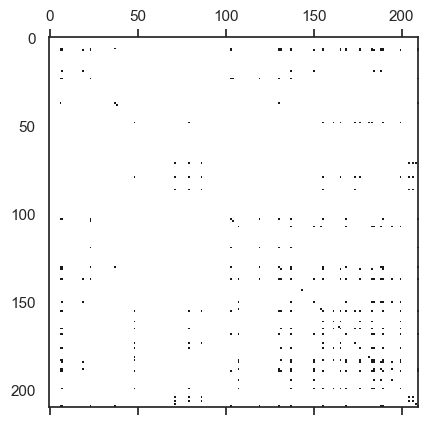

In [ ]:
B_e = np.array([t.get_edges_prob(len(Xdf.columns)) for t in trees])
plt.spy(B_e.T@B_e)

In [ ]:
# softmax(

# E_obs = _squareform(np.abs((struct.T@struct).todense()), checks=False)
E_obs = np.array([t.get_edges_prob(len(Xdf.columns), degprior=False, pseudocts=0.1) 
                  for t in trees]).mean(axis=0)
def dirichlet_mult_like(cts, alpha=0.1):
    return (cts+alpha)/(cts+alpha).sum()

E_pmf = dirichlet_mult_like(E_obs)
# E_pmf = softmax(E_pmf+1)
E_obs
# (struct.T@struct).todense()
# _random_tree_jump(count,

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.16, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.18, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.  , 0.  , 0.06, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [ ]:
est_dists = approx_dists(Xdf.values)
# est_dists = approx_dists(papers.values)

n_nodes = est_dists.shape[1]
trees = [TreeDistribution.from_subset_mode(est_dists,i) for i in Xdf.values]
# trees = [TreeDistribution.from_subset_mode(est_dists,i) for i in papers.values]

cutters = [cycle(range(t.incidence.shape[0])) for t in trees]

deps = []
nodeps=[]
hist = []
# i = 0
for it in trange(100):
    struct = sprs.vstack([t.upcast_incidence(len(Xdf.columns)) for t in trees])
    # struct = sprs.vstack([t.upcast_incidence(n_authors) for t in trees])

    E_obs = _sq(np.abs((struct.T@struct).todense()))
    ## FIGURE OUT HOW TO USE L_SYM FOR THIS TO AVOID ROOT-DOMINANCE 
    ## (UNIFORM PRIOR ON DEGREE, I GUESS??)
     
    for cutter, t in list(zip(cutters, trees)):
        mask = t.get_edge_mask(n_nodes)
        edge_in_B = -_sq(t.L())
        B_edges = np.where(edge_in_B)[0]

        e_cut = _random_cut(cutter, t.incidence, t.forest)
        
        E_obs[mask[B_edges[e_cut]]] -= 1
        E_pmf = dirichlet_mult_like(_sq(t.Lsym()), alpha=0.1)
        if np.any(E_obs<0): 
            print(mask)
            print(_squareform(t.incidence.T@t.incidence, checks=False))
            print(B_edges, mask[B_edges], E_obs[mask[B_edges]])
        e_add = _random_bridge(E_pmf[mask], t.forest)
        t.incidence[e_cut] = _std_incidence_vec(
            t.incidence.shape[1], 
            _e_to_ij(t.incidence.shape[1], e_add)
        )
        
        edge_in_B = -_squareform(t.incidence.T@t.incidence, checks=False)
        B_edges = np.where(edge_in_B)[0]
        B_not_edges = np.where(np.logical_not(edge_in_B))[0]
        nodep=np.zeros_like(E_obs)
        dep = np.zeros_like(E_obs)

        dep[mask[B_edges]] = 1
        # nodep[mask[
        deps += [dep]
        E_obs[mask[e_add]] += 1
        hist += [E_obs]
        # i+=1

  0%|                                                   | 0/100 [00:00<?, ?it/s]


IndexError: index 136 is out of bounds for axis 0 with size 21

In [ ]:
# hinton(_sq(_sq(ochiai(X))-np.array(deps).mean()))
# from scipy.stats import entropy
# entropy(_sq(ochiai(X)), _sq(outer(np.multiply,papers.sum().values/papers.shape[0])))

# plt.spy(L, marker='.')

SyntaxError: '(' was never closed (1210169449.py, line 4)

<Axes: >

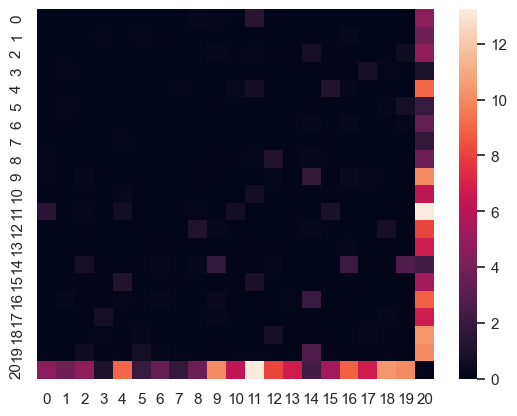

In [ ]:
sns.heatmap(_squareform(np.array(hist).mean(axis=0)))

<Axes: >

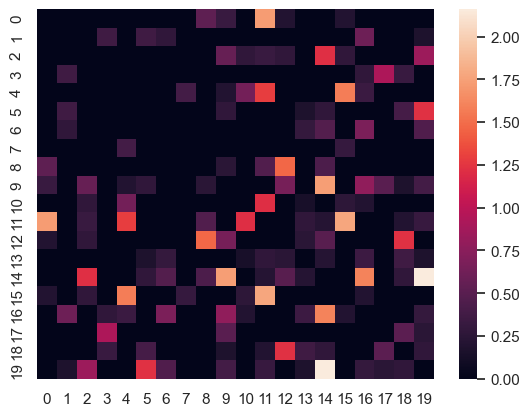

In [ ]:
sns.heatmap(_squareform(np.array(hist).std(axis=0)))

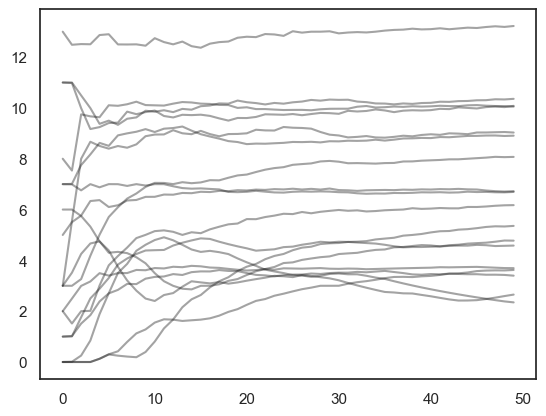

In [ ]:
plt.plot(
    (np.array(hist).cumsum(axis=0).T/np.mgrid[1:5001])[
        np.array(hist).mean(axis=0)>2,:
    ].T[np.arange(0,5000,100)],
    color='k', alpha=0.4
);

In [ ]:
_random_tree_jump(
    count(),
    E_pmf[trees[0].get_edge_mask(len(Xdf.columns))],
    trees[0].incidence, 
    trees[0].forest
)

# NOTE TO SELF: use random_cut and random_bridge, so you get the e_add and e_cut to directly put back in the 

array([[-1.,  1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  1.],
       [ 0.,  0.,  0., -1.,  1.]])

In [ ]:
trees[0]

TreeDistribution(nodes=array([ 4,  8, 14, 15, 20]), incidence=array([[-1.,  1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  1.],
       [ 0.,  0.,  0., -1.,  1.]]), forest=array([[0.61818182, 0.23636364, 0.01818182, 0.03636364, 0.09090909],
       [0.23636364, 0.47272727, 0.03636364, 0.07272727, 0.18181818],
       [0.01818182, 0.03636364, 0.61818182, 0.23636364, 0.09090909],
       [0.03636364, 0.07272727, 0.23636364, 0.47272727, 0.18181818],
       [0.09090909, 0.18181818, 0.09090909, 0.18181818, 0.45454545]]))

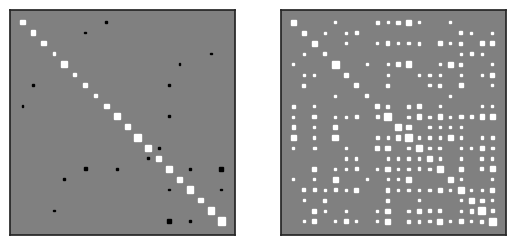

In [ ]:
plt.subplot(121)
hinton((struct.T@struct).todense())
plt.subplot(122)
hinton(coocur_prob(papers.values))

## empirical bayes (legacy)

(i.e. the first EM step)

In [ ]:
# papers

# dists = pd.DataFrame(_squareform(pdist((metadf:=Xdf).T, metric='cosine')), columns=metadf.columns, index=metadf.columns)
dists = pd.DataFrame(approx_dists(metadf:=Xdf).values, columns=metadf.columns, index=metadf.columns)

# dists = pd.DataFrame(_squareform(pdist((metadf:=Xdf).T.astype(int), metric='_sqeuclidean')), columns=metadf.columns, index=metadf.columns)
# dists = pd.DataFrame(_squareform(pdist((metadf:=Xdf).T.astype(int), metric='jaccard')), columns=metadf.columns, index=metadf.columns)

# dists =  pd.DataFrame(_squareform(prox_to_edgeprob(sinkhorn(metadf.T@metadf - np.diag(metadf.sum().values), err=1e-8))), columns=metadf.columns, index=metadf.columns)
# dists.columns.get_loc('root')
# pd.DataFrame.nan_to_num
# dists = -np.log(resource_project(metadf))
# dists = np._sqrt(1-(1-dists)**2)

#.replace(np.inf, 0.)
# pd.DataFrame.fillna(
# shortest_path(dists, indices=[0,1,5])[:,[0,1,5]]
(dists+5*np.eye(21)).apply(np.argsort).apply(lambda x: np.where(x==20)[0]+1).loc[0]

author_01     4
author_02     6
author_03     6
author_04     8
author_05     3
author_06    12
author_07     6
author_08     7
author_09     4
author_10     3
author_11     4
author_12     5
author_13     4
author_14     1
author_15     6
author_16     4
author_17     3
author_18     3
author_19     1
author_20     5
root         21
Name: 0, dtype: int64

source     target   
author_01  author_09     2
author_02  author_04     1
           author_07     1
author_04  author_18     1
author_05  author_16     5
author_06  author_02     1
author_07  author_02     1
author_09  author_13     1
author_10  author_13     1
           author_15     1
author_12  author_01     5
           author_05     8
           author_11     5
           author_16     2
author_13  author_09     3
author_15  author_03     4
           author_10     4
           author_17     4
author_16  author_08     1
author_17  author_02     1
           author_07     3
           author_15     1
author_18  author_04     1
author_19  author_03     1
           author_13     4
           author_18     3
author_20  author_03     1
           author_06     3
           author_10     1
           author_15     6
root       author_01     1
           author_02     1
           author_05     2
           author_08     1
           author_10     6
           author_11     2
       

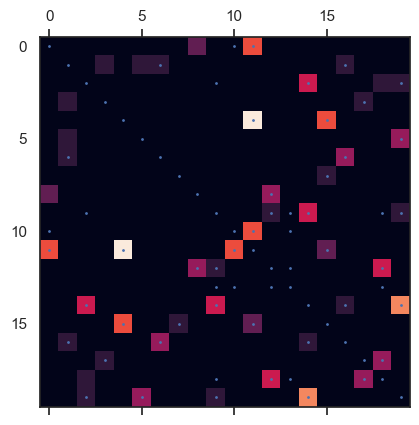

In [ ]:
def estimate_mst_basis(x, dist:pd.DataFrame, root='root'):
    # A_x = A.loc[x, x]
    
    indices = dist.columns.get_indexer(x[x].index)
    # Dx, Pr = shortest_path(dist, indices=indices,return_predecessors=True)
    
    
    # D_x = dist.loc[x, x]
    # T_stein = breadth_first_tree(minimum_spanning_tree(D_x[:,indices]).tocoo(), len(indices)-1, directed=False)
    bft = breadth_first_tree(
        minimum_spanning_tree(dist.iloc[indices,indices]),
        # minimum_spanning_tree(Dx[:,indices]), 
        # dist.columns.get_loc(root), 
        len(indices)-1,
        directed=False
    ).tocoo()

    A1obs = pd.Series(
        True, index=pd.MultiIndex.from_arrays(
            (x[x].index[bft.row],x[x].index[bft.col]), 
            names=('source','target')
    ), name='weight').astype('Sparse[bool]')
    # src,tgt = (D_x.index[np.minimum(T_stein.row, T_stein.col)], # if you want strictly lower tri_diag
    #            D_x.index[np.maximum(T_stein.row, T_stein.col)])
    # src,tgt = (dist.index[indices[T_stein.row]], dist.index[indices[T_stein.col]])
    # yield from zip(repeat(xid),src,tgt)
    return A1obs
    # return pd.Series(1, index=pd.MultiIndex.from_arrays(
    #     [src, tgt], names=['source','target']), dtype='Sparse[int]', name='weight')

def stein_edge_approx(paths, edges, holdout='meta'): 
    for u,v in edges: 
        yield from (sorted(pair) for pair in sliding_window(2, paths[u][v])) 

# dists = pd.DataFrame(_squareform(pdist((metadf:=Xdf).T, metric='_sqeuclidean')), columns=metadf.columns, index=metadf.columns)
# dists = pd.DataFrame(_squareform(pdist((metadf:=Xdf).T, metric='jaccard')), columns=metadf.columns, index=metadf.columns)


obs_edges = pd.concat([
    estimate_mst_basis(x[1], dist=dists)
    .to_frame()
    .assign(week=x[0]) 
    for x in metadf.astype(bool).iterrows()
])

L_mst= (
    obs_edges.astype('Sparse[int]')
    .groupby(['source','target'])['weight'].
    sum()
    #.unstack()
)
# L_mst = np.maximum(L_mst, L_mst.T)
L_mst=nx.to_pandas_adjacency(
    nx.from_pandas_edgelist(
        L_mst.reset_index(), edge_attr=True,
        # create_using=nx.DiGraph
    )).loc[author_idx, author_idx]

plt.imshow(L_mst)
plt.spy(L, marker='.', markersize=2)

# interp_dist(np.diag(L_mst.sum(axis=1))-L_mst)
# L_mst
obs_edges.astype('Sparse[int]').groupby(['source','target'])['weight'].sum()

In [ ]:
(obs_edges
 .astype('Sparse[int]')
 .reset_index().set_index(['week','source','target'])['weight']
 .sparse.to_coo(row_levels=['week','source'], column_levels=['target'])[0]
 .todense()
 # .sum(axis=1)
)

/tmp/ipykernel_389238/1442011135.py:3: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  .reset_index().set_index(['week','source','target'])['weight']


matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

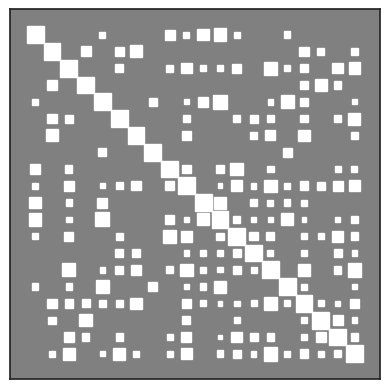

In [ ]:
hinton(ochiai(papers.values))

/home/tbsexton/Sync/code/affinis/affinis/distance.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.log(Q / norm)


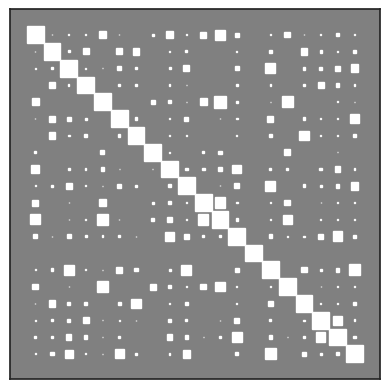

In [ ]:
# obs_edges[obs_edges.index.get_level_values('source')=='root']['week'

hinton(np.exp(-generalized_graph_dists(np.diag(L_mst.sum())-L_mst, beta=0.2)))

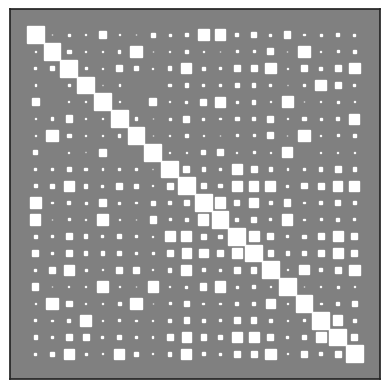

In [ ]:
hinton(np.exp(-generalized_graph_dists(L)))

In [ ]:
nx.draw(nx.from_pandas_adjacency(L_mst),pos=pos)

NameError: name 'L_mst' is not defined

In [ ]:
true.shape[0]

190

In [ ]:
IncidenceDtype = np.dtype(dict(names=author_idx.categories, formats=len(author_idx)*[np.int16]))
IncidenceDtype

IncidenceArrayDtype = np.dtype([('observation', [('incidences', IncidenceDtype)])])
IncidenceArrayDtype

dtype([('observation', [('incidences', [('author_01', '<i2'), ('author_02', '<i2'), ('author_03', '<i2'), ('author_04', '<i2'), ('author_05', '<i2'), ('author_06', '<i2'), ('author_07', '<i2'), ('author_08', '<i2'), ('author_09', '<i2'), ('author_10', '<i2'), ('author_11', '<i2'), ('author_12', '<i2'), ('author_13', '<i2'), ('author_14', '<i2'), ('author_15', '<i2'), ('author_16', '<i2'), ('author_17', '<i2'), ('author_18', '<i2'), ('author_19', '<i2'), ('author_20', '<i2')])])])

In [ ]:
dists[metadf.iloc[2].astype(bool), metadf.iloc[2].astype(bool)]

InvalidIndexError: (author_01    False
author_02    False
author_03    False
author_04     True
author_05    False
author_06    False
author_07    False
author_08    False
author_09    False
author_10    False
author_11    False
author_12     True
author_13     True
author_14     True
author_15    False
author_16    False
author_17    False
author_18    False
author_19    False
author_20    False
root          True
Name: 2, dtype: bool, author_01    False
author_02    False
author_03    False
author_04     True
author_05    False
author_06    False
author_07    False
author_08    False
author_09    False
author_10    False
author_11    False
author_12     True
author_13     True
author_14     True
author_15    False
author_16    False
author_17    False
author_18    False
author_19    False
author_20    False
root          True
Name: 2, dtype: bool)

In [ ]:
np.std(np.diag(cooc)),np.std(_squareform(cooc-np.diag(np.diag(cooc))))

(0.046013199550476516, 0.027976494863396855)

In [ ]:
forest(np.diag(L_mst.sum(axis=1))-L_mst)

array([[0.32270097, 0.        , 0.        , 0.08704139, 0.        ,
        0.        , 0.12781351, 0.15337621, 0.        , 0.        ,
        0.09678917, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07660494, 0.05722297, 0.0415328 , 0.03691804],
       [0.        , 0.28492334, 0.19352361, 0.        , 0.        ,
        0.04053121, 0.        , 0.        , 0.        , 0.04773676,
        0.        , 0.11525447, 0.06517161, 0.15588432, 0.04503468,
        0.05194   , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.19352361, 0.24217309, 0.        , 0.        ,
        0.04385344, 0.        , 0.        , 0.        , 0.05164961,
        0.        , 0.12470155, 0.07051355, 0.16866173, 0.04872605,
        0.05619737, 0.        , 0.        , 0.        , 0.        ],
       [0.08704139, 0.        , 0.        , 0.21849286, 0.        ,
        0.        , 0.09066811, 0.10880173, 0.        , 0.        ,
        0.14973191, 0.        , 0.        , 0

False

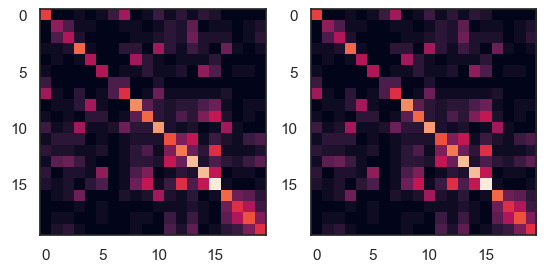

In [ ]:
plt.subplot(1,2,1)
plt.imshow((np.einsum('bi,bo->bio', X, X)).sum(axis=0))
plt.subplot(1,2,2)
plt.imshow(cooc)

np.allclose((np.einsum('bi,bo->bio', X, X)).sum(axis=0),cooc)

In [ ]:
prox_to_edgeprob((_squareform(ys[2])*np.einsum('bi,bo->bio', X, X)).sum(axis=0))

array([0.00000000e+00, 0.00000000e+00, 2.75702626e-06, 0.00000000e+00,
       4.32071741e-21, 5.58043112e-02, 1.37617295e-01, 0.00000000e+00,
       3.01001450e-19, 7.68421312e-04, 1.07631130e-13, 4.57026415e-15,
       1.06190743e-13, 9.03006838e-19, 4.25319428e-17, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.97419808e-02,
       7.71176516e-12, 1.09174642e-13, 0.00000000e+00, 0.00000000e+00,
       1.06190743e-13, 7.60563883e-12, 0.00000000e+00, 7.60709872e-12,
       5.76423516e-04, 5.43916931e-06, 8.14494849e-02, 0.00000000e+00,
       3.79636326e-08, 5.37343896e-10, 0.00000000e+00, 2.71959216e-06,
       3.84282344e-04, 1.54235303e-11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.60563883e-12, 5.37342415e-10,
       1.52141974e-11, 5.76423516e-04, 5.43916931e-06, 9.50243990e-02,
       1.07468779e-09, 7.59272651e-08, 1.07468779e-09, 0.00000000e+00,
       2.71959216e-06, 5.76423516e-04, 3.09399992e-19, 0.00000000e+00,
      

<Axes: >

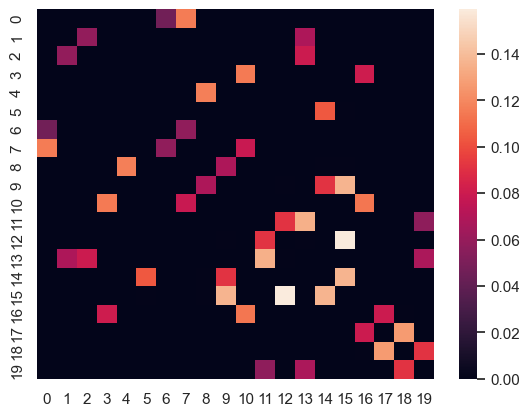

In [ ]:
edgenorm=prox_to_edgeprob((np.einsum('bi,bo->bio', X, X)*_squareform(ys[1])).sum(axis=0))
sns.heatmap(_squareform(edgenorm))

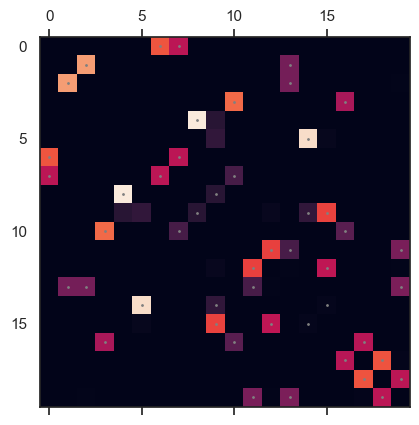

In [ ]:
norm_fac = np.asarray(forest(L, beta=0.01))
# norm_fac=np.asarray(A)
# edgenorm=norm_adj((np.einsum('bi,bo->bio', X, X)).sum(axis=0)*norm_fac) # distributive
edgenorm=prox_to_edgeprob((np.einsum('bi,bo->bio', X, X)).sum(axis=0)*norm_fac)
plt.imshow(sinkhorn(_squareform(edgenorm)))
plt.spy(L-np.diag(np.diag(L)), marker='.', markersize=2, color='grey')

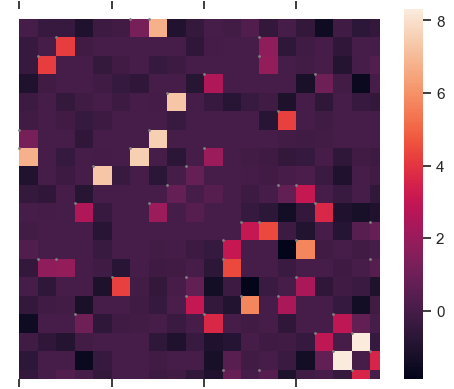

In [ ]:
glasso=_squareform(GraphicalLassoCV().fit(X).get_precision(), checks=False)

sns.heatmap(-_squareform(glasso))
plt.spy(L-np.diag(np.diag(L)), marker='.', markersize=2, color='grey')
# glasso

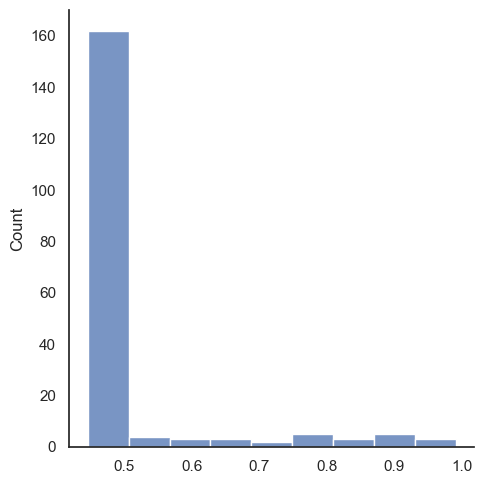

In [ ]:
sns.displot(1/(1+np.exp(glasso)))

In [ ]:
# sns.heatmap(Khat:=_prox_to_dists(sinkhorn(ochiai(np.block([[X,0],[np.eye(n_authors),-1]])))))
# np.block(
# np.searchsorted(
np.block([[X,np.ones(X.shape[0])],[np.eye(n_authors),-np.ones()]])
# for i in range(Khat.shape[0]):
    # print(np.searchsorted(Khat[i], Khat[i,-1], sorter=np.argsort(Khat)[i]))

TypeError: ones() missing 1 required positional argument: 'shape'

<Axes: >

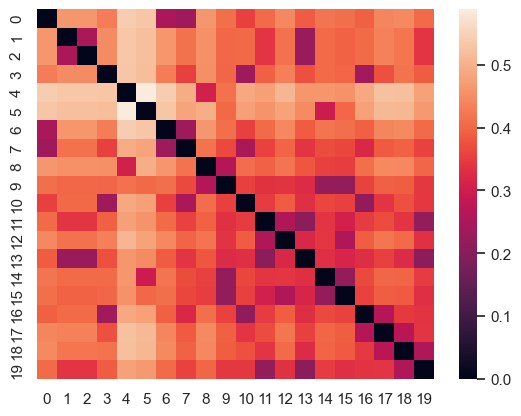

In [ ]:
sns.heatmap(adjusted_forest_dists(L, ))
# -np.log(forest(L)/np._sqrt(np.multiply.outer(np.diag(forest(L)),np.diag(forest(L)))))

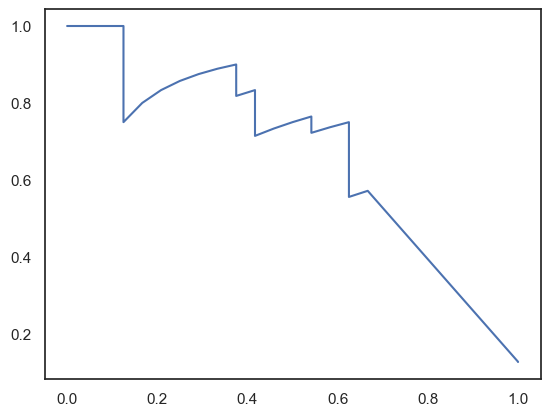

In [ ]:
# p,r,t = precision_recall_curve(true, 1/(1+np.exp(-glasso)))
p,r,t = precision_recall_curve(true, 1/(1+np.exp(glasso)))

# p,r,t = precision_recall_curve(true, edgenorm)

plt.plot(r,p)
# plt.plot(r,p)
def penrose(p,r):
    return (np.tanh(p+r)-np.tanh(p-r),np.tanh(p+r)+np.tanh(p-r))
# plt.plot(*penrose(p,r))

In [ ]:
glasso

array([ 1.80993592e-01, -0.00000000e+00,  0.00000000e+00,  2.29401877e-01,
        1.94949417e-02, -3.37789670e-01, -6.59070890e-01,  0.00000000e+00,
        5.65042506e-02, -0.00000000e+00,  3.93057983e-02,  0.00000000e+00,
       -5.61032201e-02,  1.19708305e-01,  9.16213969e-02,  1.39848663e-01,
        8.35793137e-02,  0.00000000e+00,  7.77531757e-02, -3.81160905e-01,
        0.00000000e+00,  1.34299150e-01, -3.25816069e-02, -4.13615347e-02,
        6.76621684e-03, -0.00000000e+00, -0.00000000e+00,  1.26779248e-02,
        0.00000000e+00,  6.88247037e-02, -3.10293824e-01,  5.64640635e-02,
       -0.00000000e+00,  6.87468238e-02,  1.95051959e-02,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.47578405e-02,
       -0.00000000e+00,  1.10332633e-01,  1.06921696e-01,  4.61456918e-02,
        3.42274721e-02,  0.00000000e+00,  3.01296495e-03, -2.93180161e-01,
        0.00000000e+00,  1.25512639e-01,  3.69366701e-02,  4.86703960e-02,
        1.31186053e-02,  

(array([0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758,
        0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758]),
 array([0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758,
        0.96402758, 0.96402758, 0.96402758, 0.96402758, 0.96402758]))

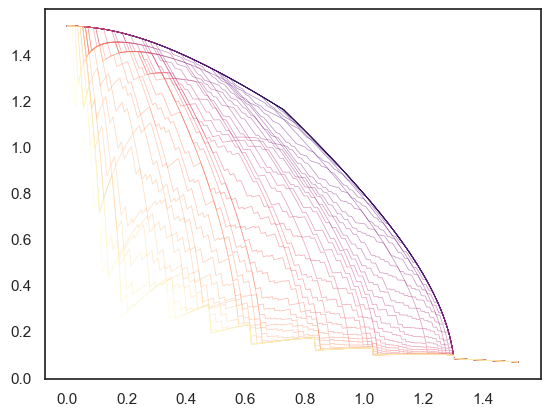

In [ ]:
def penrose(p,r):
    return (np.tanh(p+r)-np.tanh(p-r),np.tanh(p+r)+np.tanh(p-r))

for bet,c in zip(x, color):
    norm_fac = np.asarray(forest(L, beta=bet))
    # norm_fac=np.asarray(A)
    # edgenorm=norm_adj((np.einsum('bi,bo->bio', X, X)).sum(axis=0)*norm_fac) # distributive
    edgenorm=prox_to_edgeprob((np.einsum('bi,bo->bio', X, X)*norm_fac).sum(axis=0))
    
    p,r,t = precision_recall_curve(true, edgenorm)
    # plt.plot(r,p)?
    
    plt.plot(*penrose(p,r), color=c, alpha=.5, zorder=-1, lw=0.5)
    # print(t[0],t[-1])
    
# plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax = plt.gca(), values=x )
penrose(np.ones(10), np.ones(10))